In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from datetime import datetime
import sys
import argparse
from pathlib import Path

In [3]:
from june.geography import Geography
from june.demography.demography import (
    load_age_and_sex_generators_for_bins,
    Demography,
    Population,
    load_comorbidity_data,
    generate_comorbidity,
)
from june.paths import data_path, configs_path
from june.epidemiology.epidemiology import Epidemiology
from june.epidemiology.infection import ImmunitySetter
from june.epidemiology.infection import Infection, HealthIndexGenerator, InfectionSelector, InfectionSelectors
from june.epidemiology.infection_seed import InfectionSeed, InfectionSeeds
from june.interaction import Interaction
from june.groups import Hospital, Hospitals, Cemeteries
from june.distributors import HospitalDistributor
from june.hdf5_savers import generate_world_from_hdf5
from june.policy import Policy, Policies
from june.records import Record
from june.simulator import Simulator
from june.records import Record, RecordReader

from camps.activity import CampActivityManager
from camps.paths import camp_data_path, camp_configs_path
from camps.world import World
from camps.groups.leisure import generate_leisure_for_world, generate_leisure_for_config
from camps.camp_creation import (
    generate_empty_world,
    populate_world,
    distribute_people_to_households,
)  # this is loaded from the ../camp_scripts folder


No --data argument given - defaulting to:
/Users/josephbullock/Documents/campmodelling/UNGP-settlement-modelling-private/data
No --configs argument given - defaulting to:
/Users/josephbullock/Documents/covidmodelling/JUNE/june/configs


2022-01-04 14:05:36,638 - camps.paths - WARNING - No --camp_data argument given - defaulting to:
/Users/josephbullock/Documents/campmodelling/UNGP-settlement-modelling-private/camp_data
2022-01-04 14:05:36,639 - camps.paths - WARNING - No --configs_camps argument given - defaulting to:
/Users/josephbullock/Documents/campmodelling/UNGP-settlement-modelling-private/configs_camps


In [4]:
from camps.groups import PumpLatrines, PumpLatrineDistributor
from camps.groups import DistributionCenters, DistributionCenterDistributor
from camps.groups import Communals, CommunalDistributor
from camps.groups import FemaleCommunals, FemaleCommunalDistributor
from camps.groups import Religiouss, ReligiousDistributor
from camps.groups import Shelter, Shelters, ShelterDistributor
from camps.groups import IsolationUnit, IsolationUnits
from camps.groups import LearningCenters
from camps.distributors import LearningCenterDistributor
from camps.groups import PlayGroups, PlayGroupDistributor
from camps.groups import EVouchers, EVoucherDistributor
from camps.groups import NFDistributionCenters, NFDistributionCenterDistributor
from camps.groups import SheltersVisitsDistributor

## Initialize the world

When we create the camp to be simulated, we call this the 'world'. The world is initialised after specifying which geographical regions you want to simulate. We can do this by using the `filter_key` argument in the `generate_empty_world` function. Cox's Bazar Expansion Site is made up of camps (which we call regions), UNHCR blocks (which we call super areas) and Mahjee blocks (which we call areas). These are the 3 heirarchical levels on which our model works. You can pass lists of the regions/super_areas/areas to the function here. Alternatively, by leaving the function empty you can generate the entire Cox's Bazar Expansion Site consisting of 112 super areas.

In [5]:
# create empty world's geography
world = generate_empty_world(filter_key = {"region" : ["CXB-219"]})

2022-01-04 14:06:04,685 - june.geography.geography - INFO - There are 65 areas and 4 super_areas and 1 regions in the world.


In [6]:
# populate empty world
populate_world(world)

In [7]:
# distribute people to households
distribute_people_to_households(world)

In [8]:
# distirbute hospitals
hospitals = Hospitals.from_file(
    filename=camp_data_path / "input/hospitals/hospitals.csv"
)
for hospital in hospitals:
    hospital.area = world.areas.get_closest_area(hospital.coordinates)
world.hospitals = hospitals
hospital_distributor = HospitalDistributor(
    hospitals, medic_min_age=20, patients_per_medic=10
)
hospital_distributor.assign_closest_hospitals_to_super_areas(
    world.super_areas
)
hospital_distributor.distribute_medics_from_world(world.people)

2022-01-04 14:06:07,398 - hospitals - INFO - There are 8 hospitals in the world.


In [9]:
world.pump_latrines = PumpLatrines.for_areas(world.areas)
world.play_groups = PlayGroups.for_areas(world.areas)
world.distribution_centers = DistributionCenters.for_areas(world.areas)
world.communals = Communals.for_areas(world.areas)
world.female_communals = FemaleCommunals.for_areas(world.areas)
world.religiouss = Religiouss.for_areas(world.areas)
world.e_vouchers = EVouchers.for_areas(world.areas)
world.n_f_distribution_centers = NFDistributionCenters.for_areas(world.areas)

2022-01-04 14:06:08,095 - social_venue - INFO - Domain 0 has 225 pump_latrines(s)
2022-01-04 14:06:08,114 - social_venue - INFO - Domain 0 has 508 play_groups(s)
2022-01-04 14:06:08,120 - social_venue - INFO - Domain 0 has 7 distribution_centers(s)
2022-01-04 14:06:08,152 - social_venue - INFO - Domain 0 has 125 communals(s)
2022-01-04 14:06:08,171 - social_venue - INFO - Domain 0 has 67 female_communals(s)
2022-01-04 14:06:08,634 - social_venue - INFO - Domain 0 has 2064 religiouss(s)
2022-01-04 14:06:08,643 - social_venue - INFO - Domain 0 has 7 e_vouchers(s)
2022-01-04 14:06:08,654 - social_venue - INFO - Domain 0 has 36 n_f_distribution_centers(s)


In [10]:
world.cemeteries = Cemeteries()

## Geography exploration

The geography is initialised first and can be explored.

### UNHCR camp blocks inside the World

In [11]:
super_areas = []
for super_area in world.super_areas:
    super_areas.append(super_area.name)

In [12]:
super_areas[:5]

['CXB-219-A', 'CXB-219-B', 'CXB-219-C', 'CXB-219-D']

### Mahjee blocks inside World

In [13]:
areas = []
for area in world.areas:
    areas.append(area.name)

In [14]:
areas[:5]

['CXB-219-001', 'CXB-219-002', 'CXB-219-003', 'CXB-219-004', 'CXB-219-005']

## Demography exploration

Once we have populated the 'digital twin' we can explore some of the attributes of the people we have created in the simulation.

### UNHCR block residents

In [15]:
sample_ages = []
sample_sexes = []
for person in world.super_areas.members[0].people:
    sample_ages.append(person.age)
    sample_sexes.append(person.sex)

In [16]:
sample_sexes[:5], sample_ages[:5]

(['m', 'f', 'f', 'f', 'f'], [21, 17, 55, 53, 59])

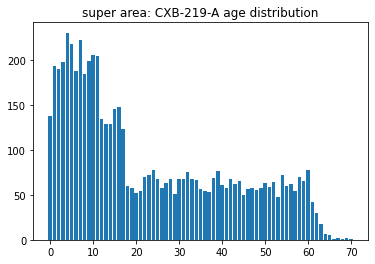

In [17]:
ages, counts = np.unique(sample_ages, return_counts=True)
plt.bar(ages, counts)
plt.title('super area: {} age distribution'.format(world.super_areas.members[0].name))
plt.show()

In [18]:
print ('The % children between ages 0-16 is {}%'.format(round(np.sum(counts[:16])/(np.sum(counts[:16])+np.sum(counts[16:]))*100)))

The % children between ages 0-16 is 49%


## Households

In this model, we will use the term 'family' and 'household' interchangeably. After populating the 'digital twin', we need to cluster people into families. To do this, we take account of age structure so that children live with adults, that there are some intergenerational households and such that we might also have some households of only adults.

### Household size distribution

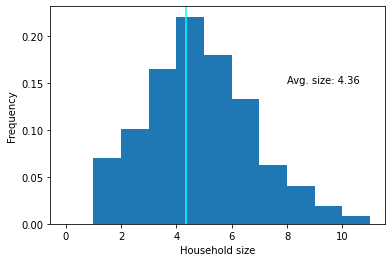

In [19]:
household_sizes = [household.size for household in world.households]
plt.hist(household_sizes, density=True, bins=np.arange(0,12))
plt.xlabel("Household size")
plt.ylabel("Frequency")
plt.axvline(np.mean(household_sizes), color="cyan")
plt.text(8, 0.150, f"Avg. size: {(np.mean(household_sizes)):.2f}")
plt.show()

# Shelters

Shelters house people in the camp. Since we know that families (houseohlds) often share shelters with other families, we can set the `sharing_shelter_ratio` to cluster families into shared shelters.

In [20]:
world.shelters = Shelters.for_areas(world.areas)
shelter_distributor = ShelterDistributor(sharing_shelter_ratio = 0.75) # proportion of families that share a shelter
for area in world.areas:
    shelter_distributor.distribute_people_in_shelters(area.shelters, area.households)

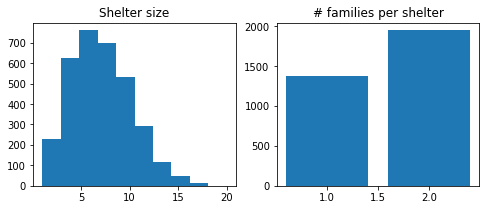

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
shelter_sizes = [shelter.size for shelter in world.shelters]
shelter_families = [shelter.n_families for shelter in world.shelters]
ax[0].hist(shelter_sizes)
ax[0].set_title("Shelter size")
shelter_families = {1 : len([shelter for shelter in world.shelters if shelter.n_families == 1]),
                    2 : len([shelter for shelter in world.shelters if shelter.n_families == 2])}
ax[1].bar(shelter_families.keys(), shelter_families.values())
ax[1].set_title("# families per shelter")
plt.show()

## Activity exploration

Once different activity locations are seeded in the 'digital twin' we can explore how many there are in different areas of the twin, and their coordinates to check they've all been added correctly.

### Pumps and latrines 

In [22]:
pumps_and_latrines = []
for pump_latrine in world.areas.members[0].pump_latrines:
    pumps_and_latrines.append(pump_latrine)

In [23]:
print ('There are {} pumps and latrines in area {}'.format(len(pumps_and_latrines), world.areas.members[0].name))

There are 4 pumps and latrines in area CXB-219-001


### Distribution centers

In [24]:
distribution_centers = []
for center in world.distribution_centers:
    distribution_centers.append(center)

In [25]:
distribution_centers[0].coordinates

array([21.21176333, 92.13597667])

### Non-food Distribution centers

In [26]:
non_food_distribution_centers = []
for center in world.n_f_distribution_centers:
    non_food_distribution_centers.append(center)

In [27]:
non_food_distribution_centers[0].coordinates

array([21.1962 , 92.14936])

### E-Voucher outlets

In [28]:
e_voucher_outlets = []
for center in world.e_vouchers:
    e_voucher_outlets.append(center)

In [29]:
e_voucher_outlets[0].coordinates

array([21.21176333, 92.13597667])

### Communal spaces

In [30]:
communal_spaces = []
for space in world.communals:
    communal_spaces.append(space)

In [31]:
communal_spaces[0].coordinates

array([21.19621, 92.14924])

### Female friendly communal spaces

In [32]:
female_communal_spaces = []
for space in world.female_communals:
    female_communal_spaces.append(space)

In [33]:
female_communal_spaces[0].coordinates

array([21.19588, 92.152  ])

### Religious sites

In [34]:
religious = []
for rel in world.religiouss:
    religious.append(rel)

In [35]:
religious[0].coordinates

array([21.20069, 92.15216])

# Adding the infection

The selector handles how infections are handled in the code. You can set different 'symptom trajectories' (e.g. exposed->mild->severe->hospitalised->intensive care) from different files. Here, we use the default.

In [36]:
selector = InfectionSelector.from_file()

In [37]:
selectors = InfectionSelectors([selector])

# Adding the interaction

The interaction class handles how many contacts people have in different locations and with who. If contact matrices are available, these can be coded in a `.yaml` file and fed into the class here.

In [38]:
interaction = Interaction.from_file(
    config_filename=camp_configs_path / "defaults/interaction/" / "ContactInteraction_med_low_low_low.yaml",
)

# Set policies

Policies control how 'operational interventions' are set in the camp. Here we set some social distancing policies, policies relating to medical care, such as people with severe symptoms being hospitalised, and individual and activity policies which can dynamically change how often and where people go, e.g. here, we close all female communal spaces and non-food distirbution centers which the camp did back in March

In [39]:
policies = Policies.from_file(
        camp_configs_path / "defaults/policy/home_care_policy.yaml",
        base_policy_modules=("june.policy", "camps.policy"),
    )

In [40]:
policies.policies

# Seed the disease

Set intial seeding conditions. This can be done at the camp level specifically, or generally by seeding them randomly. Here the `n_cases` is the number of randomly seeded people over the entire population.

In [41]:
infection_seed = InfectionSeed.from_uniform_cases(
    world=world, infection_selector=selector, cases_per_capita=0.01, date="2020-05-24"
)

In [42]:
infection_seeds = InfectionSeeds([infection_seed])

In [43]:
immunity_setter = ImmunitySetter.from_file_with_comorbidities(
    comorbidity_multipliers_path=camp_configs_path / "defaults/comorbidities.yaml",
    male_comorbidity_reference_prevalence_path= camp_data_path / "input/demography/uk_male_comorbidities.csv",
    female_comorbidity_reference_prevalence_path = camp_data_path / "input/demography/uk_female_comorbidities.csv",
    
)

In [44]:
epidemiology = Epidemiology(
    infection_selectors=selectors,
    infection_seeds=infection_seeds,
    immunity_setter=immunity_setter,
)

## Select config file

Before running the simualtion we must select the config file which defines how the world is set up and the simualtor will work. Specifically, the condif file specifies which activities will be included, how long we'll run the simualtion for, what the initial starting day will be and what the structure of weekdays and weekends will look like (if different)

In [45]:
CONFIG_PATH = "../configs_camps/config_demo.yaml"

# Initialise activities

The final step to intialising the simulator class which brings all of this together is to inialise all the activity distirbutors (the term 'leisure' is a legacy of the original version of this code used for modelling COVID-19 in the UK). This will mean that people know where they can go at and given time.

In [46]:
leisure = generate_leisure_for_config(world=world, config_filename=CONFIG_PATH)
leisure.leisure_distributors = {}
leisure.leisure_distributors["pump_latrine"] = PumpLatrineDistributor.from_config(
    world.pump_latrines
)
leisure.leisure_distributors["play_group"] = PlayGroupDistributor.from_config(
    world.play_groups
)
leisure.leisure_distributors[
    "distribution_center"
] = DistributionCenterDistributor.from_config(world.distribution_centers)
leisure.leisure_distributors["communal"] = CommunalDistributor.from_config(
    world.communals
)
leisure.leisure_distributors[
    "female_communals"
] = FemaleCommunalDistributor.from_config(world.female_communals)
leisure.leisure_distributors["religious"] = ReligiousDistributor.from_config(
    world.religiouss
)
leisure.leisure_distributors["e_voucher"] = EVoucherDistributor.from_config(
    world.e_vouchers
)
leisure.leisure_distributors[
    "n_f_distribution_center"
] = NFDistributionCenterDistributor.from_config(world.n_f_distribution_centers)
leisure.leisure_distributors[
    "shelters_visits"
] = SheltersVisitsDistributor.from_config()
leisure.leisure_distributors["shelters_visits"].link_shelters_to_shelters(
    world.super_areas
)
# associate social activities to shelters
leisure.distribute_social_venues_to_areas(world.areas, world.super_areas)

2022-01-04 14:06:38,259 - leisure - INFO - Linking households and care homes for visits
2022-01-04 14:06:38,259 - leisure - INFO - Done
2022-01-04 14:06:38,260 - leisure - INFO - Distributing social venues to areas
2022-01-04 14:06:38,260 - leisure - INFO - Distributed in 0 of 65 areas.
2022-01-04 14:06:38,342 - leisure - INFO - Distributed in 65 of 65 areas.


# Initialise simulator and run

The recorder is defined which will log all interactions and infections in the simualation for later analysis. The `record_path` can be changed to any path where you want the recorded data to be stored.

In [47]:
record = Record(
    record_path='results', 
    record_static_data=True
)


The simulator is defined with all the different necessary components we have built up so far

In [48]:
Simulator.ActivityManager = CampActivityManager
simulator = Simulator.from_file(
    world=world,
    interaction=interaction,
    leisure=leisure,
    policies=policies,
    config_filename=CONFIG_PATH,
    epidemiology=epidemiology,
    record=record,
)

Finally we can run a small simualation

In [49]:
%%time
simulator.run()

2022-01-04 14:06:44,846 - simulator - INFO - Starting simulation for 120 days at day 2020-05-24 00:00:00,to run for 120 days
2022-01-04 14:06:45,380 - rank - INFO - Next timestep
2022-01-04 14:06:45,381 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:06:45,570 - rank - INFO - Rank 0 -- move_people -- 0.18870889499999066
2022-01-04 14:06:45,570 - rank - INFO - Rank 0 -- move_people_waiting -- 3.6090000037347636e-06
2022-01-04 14:06:45,571 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.1380000109493267e-06,1.6689300537109375e-06 - 2020-05-24 00:00:00
2022-01-04 14:06:45,576 - simulator - INFO - Info for rank 0, Date = 2020-05-24 00:00:00, number of deaths =  0, number of infected = 204
2022-01-04 14:06:45,640 - rank - INFO - Rank 0 -- interaction -- 0.06889728299999831
2022-01-04 14:06:45,644 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0030906340000029786,0.00308990478515625 - 2020-05-24 00:00:00
2022-01-04 14:06:45

2022-01-04 14:06:49,696 - simulator - INFO - Info for rank 0, Date = 2020-05-25 02:00:00, number of deaths =  0, number of infected = 254
2022-01-04 14:06:49,801 - rank - INFO - Rank 0 -- interaction -- 0.11042559800000618
2022-01-04 14:06:49,805 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00018928500000470194,0.00018787384033203125 - 2020-05-25 02:00:00
2022-01-04 14:06:49,834 - rank - INFO - Rank 0 -- interaction_waiting -- 8.924999988835225e-06
2022-01-04 14:06:49,846 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011916806999991536,0.011918783187866211 - 2020-05-25 02:00:00

2022-01-04 14:06:49,848 - rank - INFO - Next timestep
2022-01-04 14:06:49,848 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:06:50,316 - rank - INFO - Rank 0 -- move_people -- 0.4669142569999991
2022-01-04 14:06:50,317 - rank - INFO - Rank 0 -- move_people_waiting -- 0.0001081059999989975
2022-01-04 14:06:50,317 - activity_manager - INFO - CMS: Peo

2022-01-04 14:06:53,775 - rank - INFO - Next timestep
2022-01-04 14:06:53,776 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:06:54,273 - rank - INFO - Rank 0 -- move_people -- 0.49622741400000336
2022-01-04 14:06:54,273 - rank - INFO - Rank 0 -- move_people_waiting -- 3.49900000173875e-06
2022-01-04 14:06:54,274 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.9979999968409174e-06,3.0994415283203125e-06 - 2020-05-26 06:00:00
2022-01-04 14:06:54,280 - simulator - INFO - Info for rank 0, Date = 2020-05-26 06:00:00, number of deaths =  0, number of infected = 352
2022-01-04 14:06:54,399 - rank - INFO - Rank 0 -- interaction -- 0.12433313599998996
2022-01-04 14:06:54,406 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.000696676000004004,0.0006959438323974609 - 2020-05-26 06:00:00
2022-01-04 14:06:54,439 - rank - INFO - Rank 0 -- interaction_waiting -- 9.521999999151376e-06
2022-01-04 14:06:54,453 - simulator - INFO - CMS: 

2022-01-04 14:06:58,594 - rank - INFO - Rank 0 -- interaction -- 0.13500540299999386
2022-01-04 14:06:58,603 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0007443420000043943,0.0007429122924804688 - 2020-05-27 08:00:00
2022-01-04 14:06:58,637 - rank - INFO - Rank 0 -- interaction_waiting -- 8.878999992134595e-06
2022-01-04 14:06:58,651 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014074378999993087,0.014076948165893555 - 2020-05-27 08:00:00

2022-01-04 14:06:58,652 - rank - INFO - Next timestep
2022-01-04 14:06:58,653 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:06:58,867 - rank - INFO - Rank 0 -- move_people -- 0.2135057299999943
2022-01-04 14:06:58,868 - rank - INFO - Rank 0 -- move_people_waiting -- 1.8375999999875603e-05
2022-01-04 14:06:58,868 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.1120000016926497e-06,2.86102294921875e-06 - 2020-05-27 10:00:00
2022-01-04 14:06:58,875 - simulator - INFO - Info

2022-01-04 14:07:02,926 - rank - INFO - Rank 0 -- move_people -- 0.21694080600001087
2022-01-04 14:07:02,926 - rank - INFO - Rank 0 -- move_people_waiting -- 4.322999998862542e-06
2022-01-04 14:07:02,927 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.5919999987754636e-06,3.0994415283203125e-06 - 2020-05-29 00:00:00
2022-01-04 14:07:02,934 - simulator - INFO - Info for rank 0, Date = 2020-05-29 00:00:00, number of deaths =  0, number of infected = 720
2022-01-04 14:07:03,008 - rank - INFO - Rank 0 -- interaction -- 0.08007614400000307
2022-01-04 14:07:03,016 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00027343399999324447,0.0002720355987548828 - 2020-05-29 00:00:00
2022-01-04 14:07:03,051 - rank - INFO - Rank 0 -- interaction_waiting -- 9.428000012690063e-06
2022-01-04 14:07:03,064 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01327813000000333,0.013279914855957031 - 2020-05-29 00:00:00

2022-01-04 14:07:03,066 - rank - INFO - Next timestep
2022-

2022-01-04 14:07:07,955 - rank - INFO - Rank 0 -- interaction_waiting -- 1.099399999304751e-05
2022-01-04 14:07:07,971 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.0158013709999949,0.015803098678588867 - 2020-05-30 03:00:00

2022-01-04 14:07:07,972 - rank - INFO - Next timestep
2022-01-04 14:07:07,973 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:07:08,534 - rank - INFO - Rank 0 -- move_people -- 0.5595933800000097
2022-01-04 14:07:08,535 - rank - INFO - Rank 0 -- move_people_waiting -- 4.424000010772033e-06
2022-01-04 14:07:08,535 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.847999991535289e-06,3.0994415283203125e-06 - 2020-05-30 05:00:00
2022-01-04 14:07:08,542 - simulator - INFO - Info for rank 0, Date = 2020-05-30 05:00:00, number of deaths =  0, number of infected = 896
2022-01-04 14:07:08,702 - rank - INFO - Rank 0 -- interaction -- 0.16598919199999784
2022-01-04 14:07:08,709 - epidemiology - INFO - CMS: Infection CO

2022-01-04 14:07:13,414 - simulator - INFO - Info for rank 0, Date = 2020-05-31 07:00:00, number of deaths =  0, number of infected = 1042
2022-01-04 14:07:13,589 - rank - INFO - Rank 0 -- interaction -- 0.18039822099999014
2022-01-04 14:07:13,594 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005192159999864998,0.0005180835723876953 - 2020-05-31 07:00:00
2022-01-04 14:07:13,633 - rank - INFO - Rank 0 -- interaction_waiting -- 9.599999998499698e-06
2022-01-04 14:07:13,647 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014041993999995839,0.014042854309082031 - 2020-05-31 07:00:00

2022-01-04 14:07:13,649 - rank - INFO - Next timestep
2022-01-04 14:07:13,650 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:07:14,207 - rank - INFO - Rank 0 -- move_people -- 0.5568001900000183
2022-01-04 14:07:14,208 - rank - INFO - Rank 0 -- move_people_waiting -- 8.500600000616032e-05
2022-01-04 14:07:14,209 - activity_manager - INFO - CMS: Peop

2022-01-04 14:07:18,553 - rank - INFO - Next timestep
2022-01-04 14:07:18,554 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:07:18,806 - rank - INFO - Rank 0 -- move_people -- 0.25133046900000977
2022-01-04 14:07:18,807 - rank - INFO - Rank 0 -- move_people_waiting -- 8.00200001549456e-06
2022-01-04 14:07:18,808 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.780999998705738e-06,5.245208740234375e-06 - 2020-06-01 10:00:00
2022-01-04 14:07:18,815 - simulator - INFO - Info for rank 0, Date = 2020-06-01 10:00:00, number of deaths =  0, number of infected = 1197
2022-01-04 14:07:18,918 - rank - INFO - Rank 0 -- interaction -- 0.10908295999999496
2022-01-04 14:07:18,957 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004300299999897561,0.0004291534423828125 - 2020-06-01 10:00:00
2022-01-04 14:07:18,998 - rank - INFO - Rank 0 -- interaction_waiting -- 9.339999991198056e-06
2022-01-04 14:07:19,012 - simulator - INFO - CMS: 

2022-01-04 14:07:23,475 - rank - INFO - Rank 0 -- interaction -- 0.08895643500000006
2022-01-04 14:07:23,482 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002897070000074109,0.0002880096435546875 - 2020-06-03 00:00:00
2022-01-04 14:07:23,523 - rank - INFO - Rank 0 -- interaction_waiting -- 1.1069999999335778e-05
2022-01-04 14:07:23,539 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015334438999985878,0.015336036682128906 - 2020-06-03 00:00:00

2022-01-04 14:07:23,540 - rank - INFO - Next timestep
2022-01-04 14:07:23,541 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:07:24,099 - rank - INFO - Rank 0 -- move_people -- 0.5578222719999815
2022-01-04 14:07:24,100 - rank - INFO - Rank 0 -- move_people_waiting -- 7.861800000341646e-05
2022-01-04 14:07:24,101 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.691000015100144e-06,4.0531158447265625e-06 - 2020-06-03 02:00:00
2022-01-04 14:07:24,108 - simulator - INFO - Inf

2022-01-04 14:07:28,951 - rank - INFO - Rank 0 -- move_people -- 0.5568992720000097
2022-01-04 14:07:28,952 - rank - INFO - Rank 0 -- move_people_waiting -- 7.950599999162478e-05
2022-01-04 14:07:28,953 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.0850000030113733e-06,2.86102294921875e-06 - 2020-06-04 04:00:00
2022-01-04 14:07:28,960 - simulator - INFO - Info for rank 0, Date = 2020-06-04 04:00:00, number of deaths =  0, number of infected = 1574
2022-01-04 14:07:29,131 - rank - INFO - Rank 0 -- interaction -- 0.17710233799999742
2022-01-04 14:07:29,137 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0007145960000229934,0.0007128715515136719 - 2020-06-04 04:00:00
2022-01-04 14:07:29,184 - rank - INFO - Rank 0 -- interaction_waiting -- 9.97200001506826e-06
2022-01-04 14:07:29,199 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014987867999991522,0.014989852905273438 - 2020-06-04 04:00:00

2022-01-04 14:07:29,201 - rank - INFO - Next timestep
2022-01-

2022-01-04 14:07:34,153 - rank - INFO - Rank 0 -- interaction_waiting -- 9.834000024966372e-06
2022-01-04 14:07:34,169 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015484718999999814,0.015488147735595703 - 2020-06-05 06:00:00

2022-01-04 14:07:34,170 - rank - INFO - Next timestep
2022-01-04 14:07:34,171 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:07:34,741 - rank - INFO - Rank 0 -- move_people -- 0.5693366489999789
2022-01-04 14:07:34,742 - rank - INFO - Rank 0 -- move_people_waiting -- 7.901000003585068e-06
2022-01-04 14:07:34,742 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.154999999173015e-06,3.0994415283203125e-06 - 2020-06-05 08:00:00
2022-01-04 14:07:34,750 - simulator - INFO - Info for rank 0, Date = 2020-06-05 08:00:00, number of deaths =  0, number of infected = 1731
2022-01-04 14:07:34,924 - rank - INFO - Rank 0 -- interaction -- 0.1800850809999872
2022-01-04 14:07:34,931 - epidemiology - INFO - CMS: Infection 

2022-01-04 14:07:39,338 - simulator - INFO - Info for rank 0, Date = 2020-06-06 11:00:00, number of deaths =  0, number of infected = 1876
2022-01-04 14:07:39,434 - rank - INFO - Rank 0 -- interaction -- 0.10301739299998758
2022-01-04 14:07:39,465 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00023987000000147418,0.0002391338348388672 - 2020-06-06 11:00:00
2022-01-04 14:07:39,509 - rank - INFO - Rank 0 -- interaction_waiting -- 0.00021010300000057214
2022-01-04 14:07:39,524 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015321066000012706,0.015323162078857422 - 2020-06-06 11:00:00

2022-01-04 14:07:39,526 - rank - INFO - Next timestep
2022-01-04 14:07:39,527 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:07:39,766 - rank - INFO - Rank 0 -- move_people -- 0.23902976200000126
2022-01-04 14:07:39,767 - rank - INFO - Rank 0 -- move_people_waiting -- 4.159000013714831e-06
2022-01-04 14:07:39,767 - activity_manager - INFO - CMS: P

2022-01-04 14:07:44,061 - rank - INFO - Next timestep
2022-01-04 14:07:44,061 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:07:44,620 - rank - INFO - Rank 0 -- move_people -- 0.5580496069999867
2022-01-04 14:07:44,621 - rank - INFO - Rank 0 -- move_people_waiting -- 0.0001037430000110362
2022-01-04 14:07:44,622 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.187999991245306e-06,4.0531158447265625e-06 - 2020-06-08 02:00:00
2022-01-04 14:07:44,629 - simulator - INFO - Info for rank 0, Date = 2020-06-08 02:00:00, number of deaths =  0, number of infected = 2084
2022-01-04 14:07:44,804 - rank - INFO - Rank 0 -- interaction -- 0.1817929660000175
2022-01-04 14:07:44,810 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006527160000189269,0.0006508827209472656 - 2020-06-08 02:00:00
2022-01-04 14:07:44,860 - rank - INFO - Rank 0 -- interaction_waiting -- 1.2217000005421141e-05
2022-01-04 14:07:44,876 - simulator - INFO - CMS:

2022-01-04 14:07:49,626 - rank - INFO - Rank 0 -- interaction -- 0.1785336519999987
2022-01-04 14:07:49,632 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006991420000019843,0.0006992816925048828 - 2020-06-09 04:00:00
2022-01-04 14:07:49,680 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0972000012543504e-05
2022-01-04 14:07:49,695 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014046591000010267,0.014047861099243164 - 2020-06-09 04:00:00

2022-01-04 14:07:49,696 - rank - INFO - Next timestep
2022-01-04 14:07:49,697 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:07:50,242 - rank - INFO - Rank 0 -- move_people -- 0.5443504209999901
2022-01-04 14:07:50,243 - rank - INFO - Rank 0 -- move_people_waiting -- 0.0001400350000153594
2022-01-04 14:07:50,244 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.35100000370403e-06,3.0994415283203125e-06 - 2020-06-09 06:00:00
2022-01-04 14:07:50,250 - simulator - INFO - Info 

2022-01-04 14:07:55,043 - rank - INFO - Rank 0 -- move_people -- 0.5417649640000093
2022-01-04 14:07:55,044 - rank - INFO - Rank 0 -- move_people_waiting -- 7.559200000173405e-05
2022-01-04 14:07:55,044 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.112000027589602e-06,4.0531158447265625e-06 - 2020-06-10 08:00:00
2022-01-04 14:07:55,051 - simulator - INFO - Info for rank 0, Date = 2020-06-10 08:00:00, number of deaths =  0, number of infected = 2293
2022-01-04 14:07:55,225 - rank - INFO - Rank 0 -- interaction -- 0.18018225999998094
2022-01-04 14:07:55,231 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004149009999991904,0.00041484832763671875 - 2020-06-10 08:00:00
2022-01-04 14:07:55,279 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0013000007802475e-05
2022-01-04 14:07:55,293 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013952689000007013,0.013953924179077148 - 2020-06-10 08:00:00

2022-01-04 14:07:55,294 - rank - INFO - Next timestep
2022

2022-01-04 14:07:59,749 - rank - INFO - Rank 0 -- interaction_waiting -- 9.862000013072247e-06
2022-01-04 14:07:59,763 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014158473999998478,0.014161109924316406 - 2020-06-11 10:00:00

2022-01-04 14:07:59,765 - rank - INFO - Next timestep
2022-01-04 14:07:59,766 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:07:59,998 - rank - INFO - Rank 0 -- move_people -- 0.23215771599998902
2022-01-04 14:07:59,999 - rank - INFO - Rank 0 -- move_people_waiting -- 7.113000009439929e-06
2022-01-04 14:08:00,000 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.634999982044974e-06,5.0067901611328125e-06 - 2020-06-12 00:00:00
2022-01-04 14:08:00,007 - simulator - INFO - Info for rank 0, Date = 2020-06-12 00:00:00, number of deaths =  0, number of infected = 2435
2022-01-04 14:08:00,101 - rank - INFO - Rank 0 -- interaction -- 0.10056613800000491
2022-01-04 14:08:00,106 - epidemiology - INFO - CMS: Infectio

2022-01-04 14:08:04,719 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.3259999838719523e-06,2.6226043701171875e-06 - 2020-06-13 03:00:00
2022-01-04 14:08:04,725 - simulator - INFO - Info for rank 0, Date = 2020-06-13 03:00:00, number of deaths =  0, number of infected = 2529
2022-01-04 14:08:04,902 - rank - INFO - Rank 0 -- interaction -- 0.18221205599999735
2022-01-04 14:08:04,907 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002718020000145316,0.0002701282501220703 - 2020-06-13 03:00:00
2022-01-04 14:08:04,955 - rank - INFO - Rank 0 -- interaction_waiting -- 1.1962000002085915e-05
2022-01-04 14:08:04,969 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014184388999979092,0.014184951782226562 - 2020-06-13 03:00:00

2022-01-04 14:08:04,971 - rank - INFO - Next timestep
2022-01-04 14:08:04,972 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:08:05,507 - rank - INFO - Rank 0 -- move_people -- 0.5348941750000051
202

2022-01-04 14:08:09,735 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014740270999993754,0.01474308967590332 - 2020-06-14 05:00:00

2022-01-04 14:08:09,737 - rank - INFO - Next timestep
2022-01-04 14:08:09,737 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:08:10,266 - rank - INFO - Rank 0 -- move_people -- 0.5280115640000247
2022-01-04 14:08:10,267 - rank - INFO - Rank 0 -- move_people_waiting -- 7.491599998843412e-05
2022-01-04 14:08:10,267 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.2690000182356016e-06,3.0994415283203125e-06 - 2020-06-14 07:00:00
2022-01-04 14:08:10,274 - simulator - INFO - Info for rank 0, Date = 2020-06-14 07:00:00, number of deaths =  0, number of infected = 2635
2022-01-04 14:08:10,447 - rank - INFO - Rank 0 -- interaction -- 0.17929414400001065
2022-01-04 14:08:10,459 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002862629999924593,0.00028586387634277344 - 2020-06-14 07:00:00
2022

2022-01-04 14:08:15,034 - simulator - INFO - Info for rank 0, Date = 2020-06-15 08:00:00, number of deaths =  0, number of infected = 2736
2022-01-04 14:08:15,213 - rank - INFO - Rank 0 -- interaction -- 0.18491850600000248
2022-01-04 14:08:15,220 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00022511299999905532,0.0002238750457763672 - 2020-06-15 08:00:00
2022-01-04 14:08:15,269 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0627999984080816e-05
2022-01-04 14:08:15,283 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01361720699998159,0.013618946075439453 - 2020-06-15 08:00:00

2022-01-04 14:08:15,285 - rank - INFO - Next timestep
2022-01-04 14:08:15,285 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:08:15,512 - rank - INFO - Rank 0 -- move_people -- 0.2261842540000032
2022-01-04 14:08:15,513 - rank - INFO - Rank 0 -- move_people_waiting -- 7.729200001449499e-05
2022-01-04 14:08:15,513 - activity_manager - INFO - CMS: Peo

2022-01-04 14:08:19,752 - rank - INFO - Next timestep
2022-01-04 14:08:19,752 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:08:19,979 - rank - INFO - Rank 0 -- move_people -- 0.22630200799997624
2022-01-04 14:08:19,980 - rank - INFO - Rank 0 -- move_people_waiting -- 3.92100000112805e-06
2022-01-04 14:08:19,980 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.1010000043352193e-06,3.0994415283203125e-06 - 2020-06-17 00:00:00
2022-01-04 14:08:19,987 - simulator - INFO - Info for rank 0, Date = 2020-06-17 00:00:00, number of deaths =  0, number of infected = 2829
2022-01-04 14:08:20,086 - rank - INFO - Rank 0 -- interaction -- 0.104605590999995
2022-01-04 14:08:20,095 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006459770000049048,0.0006439685821533203 - 2020-06-17 00:00:00
2022-01-04 14:08:20,148 - rank - INFO - Rank 0 -- interaction_waiting -- 0.00011489900001038222
2022-01-04 14:08:20,162 - simulator - INFO - CMS:

2022-01-04 14:08:24,903 - rank - INFO - Rank 0 -- interaction -- 0.18880345499999862
2022-01-04 14:08:24,911 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00026205699998627097,0.0002613067626953125 - 2020-06-18 02:00:00
2022-01-04 14:08:24,961 - rank - INFO - Rank 0 -- interaction_waiting -- 9.268000013662459e-06
2022-01-04 14:08:24,975 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013875559000013027,0.01387786865234375 - 2020-06-18 02:00:00

2022-01-04 14:08:24,976 - rank - INFO - Next timestep
2022-01-04 14:08:24,977 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:08:25,506 - rank - INFO - Rank 0 -- move_people -- 0.5290213800000174
2022-01-04 14:08:25,507 - rank - INFO - Rank 0 -- move_people_waiting -- 1.009899997939101e-05
2022-01-04 14:08:25,508 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.660000004401809e-06,3.0994415283203125e-06 - 2020-06-18 04:00:00
2022-01-04 14:08:25,515 - simulator - INFO - Info

2022-01-04 14:08:30,375 - rank - INFO - Rank 0 -- move_people -- 0.530792813000005
2022-01-04 14:08:30,376 - rank - INFO - Rank 0 -- move_people_waiting -- 3.848000005746144e-06
2022-01-04 14:08:30,376 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.553999988525902e-06,3.0994415283203125e-06 - 2020-06-19 06:00:00
2022-01-04 14:08:30,383 - simulator - INFO - Info for rank 0, Date = 2020-06-19 06:00:00, number of deaths =  0, number of infected = 2953
2022-01-04 14:08:30,569 - rank - INFO - Rank 0 -- interaction -- 0.1918014430000028
2022-01-04 14:08:30,578 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0008621990000108326,0.0008656978607177734 - 2020-06-19 06:00:00
2022-01-04 14:08:30,631 - rank - INFO - Rank 0 -- interaction_waiting -- 9.359000017639119e-06
2022-01-04 14:08:30,645 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013621760000006589,0.01362299919128418 - 2020-06-19 06:00:00

2022-01-04 14:08:30,647 - rank - INFO - Next timestep
2022-01-0

2022-01-04 14:08:35,679 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0302000021056301e-05
2022-01-04 14:08:35,693 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013907999000025484,0.013908863067626953 - 2020-06-20 09:00:00

2022-01-04 14:08:35,694 - rank - INFO - Next timestep
2022-01-04 14:08:35,695 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:08:35,933 - rank - INFO - Rank 0 -- move_people -- 0.2379871360000152
2022-01-04 14:08:35,934 - rank - INFO - Rank 0 -- move_people_waiting -- 4.219000004468398e-06
2022-01-04 14:08:35,935 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.185999986499155e-06,2.86102294921875e-06 - 2020-06-20 11:00:00
2022-01-04 14:08:35,941 - simulator - INFO - Info for rank 0, Date = 2020-06-20 11:00:00, number of deaths =  0, number of infected = 3018
2022-01-04 14:08:36,063 - rank - INFO - Rank 0 -- interaction -- 0.12720851399998878
2022-01-04 14:08:36,100 - epidemiology - INFO - CMS: Infection 

2022-01-04 14:08:40,712 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.083999982640307e-06,3.814697265625e-06 - 2020-06-22 00:00:00
2022-01-04 14:08:40,719 - simulator - INFO - Info for rank 0, Date = 2020-06-22 00:00:00, number of deaths =  0, number of infected = 3122
2022-01-04 14:08:40,831 - rank - INFO - Rank 0 -- interaction -- 0.11896128300000441
2022-01-04 14:08:40,840 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003625460000193925,0.0003609657287597656 - 2020-06-22 00:00:00
2022-01-04 14:08:40,894 - rank - INFO - Rank 0 -- interaction_waiting -- 1.3644999995676699e-05
2022-01-04 14:08:40,908 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013902816000012308,0.013905048370361328 - 2020-06-22 00:00:00

2022-01-04 14:08:40,910 - rank - INFO - Next timestep
2022-01-04 14:08:40,911 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:08:41,458 - rank - INFO - Rank 0 -- move_people -- 0.5466721010000128
2022-01-

2022-01-04 14:08:46,050 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014038016000000653,0.014039993286132812 - 2020-06-23 02:00:00

2022-01-04 14:08:46,051 - rank - INFO - Next timestep
2022-01-04 14:08:46,052 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:08:46,602 - rank - INFO - Rank 0 -- move_people -- 0.5491402769999922
2022-01-04 14:08:46,604 - rank - INFO - Rank 0 -- move_people_waiting -- 0.0005152079999959369
2022-01-04 14:08:46,606 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.851000002441651e-06,3.0994415283203125e-06 - 2020-06-23 04:00:00
2022-01-04 14:08:46,612 - simulator - INFO - Info for rank 0, Date = 2020-06-23 04:00:00, number of deaths =  0, number of infected = 3166
2022-01-04 14:08:46,810 - rank - INFO - Rank 0 -- interaction -- 0.20419901200000368
2022-01-04 14:08:46,816 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002745910000214735,0.0002739429473876953 - 2020-06-23 04:00:00
2022-

2022-01-04 14:08:51,689 - simulator - INFO - Info for rank 0, Date = 2020-06-24 06:00:00, number of deaths =  0, number of infected = 3184
2022-01-04 14:08:51,893 - rank - INFO - Rank 0 -- interaction -- 0.2098308469999779
2022-01-04 14:08:51,901 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00042611399999259447,0.0004260540008544922 - 2020-06-24 06:00:00
2022-01-04 14:08:51,953 - rank - INFO - Rank 0 -- interaction_waiting -- 0.00010625900000604815
2022-01-04 14:08:51,967 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014149595000020554,0.014151811599731445 - 2020-06-24 06:00:00

2022-01-04 14:08:51,969 - rank - INFO - Next timestep
2022-01-04 14:08:51,970 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:08:52,526 - rank - INFO - Rank 0 -- move_people -- 0.555149718999985
2022-01-04 14:08:52,527 - rank - INFO - Rank 0 -- move_people_waiting -- 9.914800000387913e-05
2022-01-04 14:08:52,527 - activity_manager - INFO - CMS: Peop

2022-01-04 14:08:57,179 - rank - INFO - Next timestep
2022-01-04 14:08:57,179 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:08:57,415 - rank - INFO - Rank 0 -- move_people -- 0.2349500589999991
2022-01-04 14:08:57,416 - rank - INFO - Rank 0 -- move_people_waiting -- 3.972000001795095e-06
2022-01-04 14:08:57,416 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.238000005012509e-06,1.9073486328125e-06 - 2020-06-25 10:00:00
2022-01-04 14:08:57,423 - simulator - INFO - Info for rank 0, Date = 2020-06-25 10:00:00, number of deaths =  0, number of infected = 3216
2022-01-04 14:08:57,551 - rank - INFO - Rank 0 -- interaction -- 0.1341338139999948
2022-01-04 14:08:57,581 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004540889999873343,0.000453948974609375 - 2020-06-25 10:00:00
2022-01-04 14:08:57,634 - rank - INFO - Rank 0 -- interaction_waiting -- 9.874999989278876e-06
2022-01-04 14:08:57,648 - simulator - INFO - CMS: Time

2022-01-04 14:09:02,309 - rank - INFO - Rank 0 -- interaction -- 0.12668660500000328
2022-01-04 14:09:02,317 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00037500899998121895,0.00037407875061035156 - 2020-06-27 00:00:00
2022-01-04 14:09:02,370 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0234000001219101e-05
2022-01-04 14:09:02,385 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014027424999994764,0.014029979705810547 - 2020-06-27 00:00:00

2022-01-04 14:09:02,386 - rank - INFO - Next timestep
2022-01-04 14:09:02,387 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:09:02,937 - rank - INFO - Rank 0 -- move_people -- 0.5490930199999866
2022-01-04 14:09:02,938 - rank - INFO - Rank 0 -- move_people_waiting -- 9.268800002359967e-05
2022-01-04 14:09:02,938 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.896999999142281e-06,2.6226043701171875e-06 - 2020-06-27 03:00:00
2022-01-04 14:09:02,945 - simulator - INFO - I

2022-01-04 14:09:08,092 - rank - INFO - Rank 0 -- move_people -- 0.5558855509999887
2022-01-04 14:09:08,093 - rank - INFO - Rank 0 -- move_people_waiting -- 0.0001005070000132946
2022-01-04 14:09:08,093 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.460999977278334e-06,3.0994415283203125e-06 - 2020-06-28 05:00:00
2022-01-04 14:09:08,100 - simulator - INFO - Info for rank 0, Date = 2020-06-28 05:00:00, number of deaths =  0, number of infected = 3258
2022-01-04 14:09:08,306 - rank - INFO - Rank 0 -- interaction -- 0.21205529400000955
2022-01-04 14:09:08,311 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006903109999996104,0.0006902217864990234 - 2020-06-28 05:00:00
2022-01-04 14:09:08,365 - rank - INFO - Rank 0 -- interaction_waiting -- 1.4050999993742153e-05
2022-01-04 14:09:08,379 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014317132000002175,0.01431894302368164 - 2020-06-28 05:00:00

2022-01-04 14:09:08,381 - rank - INFO - Next timestep
2022-0

2022-01-04 14:09:13,527 - rank - INFO - Rank 0 -- interaction_waiting -- 9.959000010439922e-06
2022-01-04 14:09:13,542 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01502666100000738,0.015028953552246094 - 2020-06-29 06:00:00

2022-01-04 14:09:13,544 - rank - INFO - Next timestep
2022-01-04 14:09:13,544 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:09:14,095 - rank - INFO - Rank 0 -- move_people -- 0.5499815249999926
2022-01-04 14:09:14,096 - rank - INFO - Rank 0 -- move_people_waiting -- 3.961000004437665e-06
2022-01-04 14:09:14,096 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.193000026158188e-06,1.9073486328125e-06 - 2020-06-29 08:00:00
2022-01-04 14:09:14,103 - simulator - INFO - Info for rank 0, Date = 2020-06-29 08:00:00, number of deaths =  1, number of infected = 3322
2022-01-04 14:09:14,311 - rank - INFO - Rank 0 -- interaction -- 0.21375594700000988
2022-01-04 14:09:14,318 - epidemiology - INFO - CMS: Infection COM

2022-01-04 14:09:18,962 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.4010000124217186e-06,4.0531158447265625e-06 - 2020-06-30 10:00:00
2022-01-04 14:09:18,969 - simulator - INFO - Info for rank 0, Date = 2020-06-30 10:00:00, number of deaths =  1, number of infected = 3396
2022-01-04 14:09:19,106 - rank - INFO - Rank 0 -- interaction -- 0.14268747500000245
2022-01-04 14:09:19,145 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006875169999602804,0.0006866455078125 - 2020-06-30 10:00:00
2022-01-04 14:09:19,201 - rank - INFO - Rank 0 -- interaction_waiting -- 9.108000028845709e-06
2022-01-04 14:09:19,215 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013608108000028096,0.013609886169433594 - 2020-06-30 10:00:00

2022-01-04 14:09:19,216 - rank - INFO - Next timestep
2022-01-04 14:09:19,217 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:09:19,455 - rank - INFO - Rank 0 -- move_people -- 0.2370886190000192
2022-01

2022-01-04 14:09:23,982 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014749017000042386,0.014750957489013672 - 2020-07-02 00:00:00

2022-01-04 14:09:23,984 - rank - INFO - Next timestep
2022-01-04 14:09:23,984 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:09:24,535 - rank - INFO - Rank 0 -- move_people -- 0.5498865989999899
2022-01-04 14:09:24,536 - rank - INFO - Rank 0 -- move_people_waiting -- 6.88400001536138e-06
2022-01-04 14:09:24,536 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.3190000294780475e-06,2.86102294921875e-06 - 2020-07-02 02:00:00
2022-01-04 14:09:24,544 - simulator - INFO - Info for rank 0, Date = 2020-07-02 02:00:00, number of deaths =  1, number of infected = 3473
2022-01-04 14:09:24,748 - rank - INFO - Rank 0 -- interaction -- 0.2102813230000038
2022-01-04 14:09:24,754 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005889209999736522,0.0005881786346435547 - 2020-07-02 02:00:00
2022-01-

2022-01-04 14:09:29,641 - simulator - INFO - Info for rank 0, Date = 2020-07-03 04:00:00, number of deaths =  1, number of infected = 3544
2022-01-04 14:09:29,844 - rank - INFO - Rank 0 -- interaction -- 0.20854045499999074
2022-01-04 14:09:29,848 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003618420000179867,0.0003609657287597656 - 2020-07-03 04:00:00
2022-01-04 14:09:29,903 - rank - INFO - Rank 0 -- interaction_waiting -- 9.49499997204839e-06
2022-01-04 14:09:29,917 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013884808999989673,0.01388692855834961 - 2020-07-03 04:00:00

2022-01-04 14:09:29,919 - rank - INFO - Next timestep
2022-01-04 14:09:29,920 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:09:30,461 - rank - INFO - Rank 0 -- move_people -- 0.5407673099999784
2022-01-04 14:09:30,462 - rank - INFO - Rank 0 -- move_people_waiting -- 7.765000020754087e-06
2022-01-04 14:09:30,463 - activity_manager - INFO - CMS: People

2022-01-04 14:09:34,988 - rank - INFO - Next timestep
2022-01-04 14:09:34,989 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:09:35,526 - rank - INFO - Rank 0 -- move_people -- 0.536467526000024
2022-01-04 14:09:35,527 - rank - INFO - Rank 0 -- move_people_waiting -- 7.325000012770033e-06
2022-01-04 14:09:35,527 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.3379999990756914e-06,1.9073486328125e-06 - 2020-07-04 09:00:00
2022-01-04 14:09:35,534 - simulator - INFO - Info for rank 0, Date = 2020-07-04 09:00:00, number of deaths =  1, number of infected = 3586
2022-01-04 14:09:35,731 - rank - INFO - Rank 0 -- interaction -- 0.20304697099999203
2022-01-04 14:09:35,738 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005602549999821349,0.0005588531494140625 - 2020-07-04 09:00:00
2022-01-04 14:09:35,793 - rank - INFO - Rank 0 -- interaction_waiting -- 9.782999995877617e-06
2022-01-04 14:09:35,807 - simulator - INFO - CMS: Ti

2022-01-04 14:09:40,394 - rank - INFO - Rank 0 -- interaction -- 0.13898265599999604
2022-01-04 14:09:40,428 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00040260999998054103,0.0004019737243652344 - 2020-07-05 11:00:00
2022-01-04 14:09:40,483 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0608999957639753e-05
2022-01-04 14:09:40,496 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013577803999964999,0.013579607009887695 - 2020-07-05 11:00:00

2022-01-04 14:09:40,498 - rank - INFO - Next timestep
2022-01-04 14:09:40,499 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:09:40,730 - rank - INFO - Rank 0 -- move_people -- 0.2307359980000001
2022-01-04 14:09:40,731 - rank - INFO - Rank 0 -- move_people_waiting -- 8.757800003422744e-05
2022-01-04 14:09:40,731 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.155000001697772e-06,2.86102294921875e-06 - 2020-07-06 00:00:00
2022-01-04 14:09:40,738 - simulator - INFO - Info

2022-01-04 14:09:45,699 - rank - INFO - Rank 0 -- move_people -- 0.5315431309999781
2022-01-04 14:09:45,700 - rank - INFO - Rank 0 -- move_people_waiting -- 0.00010183299997379436
2022-01-04 14:09:45,700 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.218000015043799e-06,4.0531158447265625e-06 - 2020-07-07 02:00:00
2022-01-04 14:09:45,707 - simulator - INFO - Info for rank 0, Date = 2020-07-07 02:00:00, number of deaths =  1, number of infected = 3696
2022-01-04 14:09:45,907 - rank - INFO - Rank 0 -- interaction -- 0.2063750970000342
2022-01-04 14:09:45,917 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003043010000283175,0.0003032684326171875 - 2020-07-07 02:00:00
2022-01-04 14:09:45,972 - rank - INFO - Rank 0 -- interaction_waiting -- 1.33580000465372e-05
2022-01-04 14:09:45,985 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013632016000030944,0.013633966445922852 - 2020-07-07 02:00:00

2022-01-04 14:09:45,987 - rank - INFO - Next timestep
2022-01

2022-01-04 14:09:50,996 - rank - INFO - Rank 0 -- interaction_waiting -- 9.99500002762943e-06
2022-01-04 14:09:51,010 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01372079200001508,0.013721942901611328 - 2020-07-08 04:00:00

2022-01-04 14:09:51,012 - rank - INFO - Next timestep
2022-01-04 14:09:51,012 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:09:51,547 - rank - INFO - Rank 0 -- move_people -- 0.5335759860000167
2022-01-04 14:09:51,547 - rank - INFO - Rank 0 -- move_people_waiting -- 4.486999955588544e-06
2022-01-04 14:09:51,548 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.355000044142798e-06,4.0531158447265625e-06 - 2020-07-08 06:00:00
2022-01-04 14:09:51,555 - simulator - INFO - Info for rank 0, Date = 2020-07-08 06:00:00, number of deaths =  1, number of infected = 3717
2022-01-04 14:09:51,759 - rank - INFO - Rank 0 -- interaction -- 0.21044083500004263
2022-01-04 14:09:51,767 - epidemiology - INFO - CMS: Infection C

2022-01-04 14:09:56,607 - simulator - INFO - Info for rank 0, Date = 2020-07-09 08:00:00, number of deaths =  1, number of infected = 3741
2022-01-04 14:09:56,807 - rank - INFO - Rank 0 -- interaction -- 0.20633980400003793
2022-01-04 14:09:56,813 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006869599999959064,0.0006859302520751953 - 2020-07-09 08:00:00
2022-01-04 14:09:56,869 - rank - INFO - Rank 0 -- interaction_waiting -- 1.3503999980457593e-05
2022-01-04 14:09:56,883 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013720653999996557,0.013721942901611328 - 2020-07-09 08:00:00

2022-01-04 14:09:56,884 - rank - INFO - Next timestep
2022-01-04 14:09:56,885 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:09:57,115 - rank - INFO - Rank 0 -- move_people -- 0.22963284000002204
2022-01-04 14:09:57,116 - rank - INFO - Rank 0 -- move_people_waiting -- 3.933000016331789e-06
2022-01-04 14:09:57,116 - activity_manager - INFO - CMS: Pe

2022-01-04 14:10:01,634 - rank - INFO - Next timestep
2022-01-04 14:10:01,635 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:10:01,868 - rank - INFO - Rank 0 -- move_people -- 0.23265694399998438
2022-01-04 14:10:01,869 - rank - INFO - Rank 0 -- move_people_waiting -- 3.764000041428517e-06
2022-01-04 14:10:01,869 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.934999997705745e-06,2.86102294921875e-06 - 2020-07-11 00:00:00
2022-01-04 14:10:01,876 - simulator - INFO - Info for rank 0, Date = 2020-07-11 00:00:00, number of deaths =  1, number of infected = 3803
2022-01-04 14:10:01,999 - rank - INFO - Rank 0 -- interaction -- 0.1291781390000324
2022-01-04 14:10:02,008 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00030232000000296466,0.0003008842468261719 - 2020-07-11 00:00:00
2022-01-04 14:10:02,064 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0290999966855452e-05
2022-01-04 14:10:02,079 - simulator - INFO - CMS:

2022-01-04 14:10:07,095 - rank - INFO - Rank 0 -- interaction -- 0.20451263400002517
2022-01-04 14:10:07,100 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00024059599996917314,0.00023984909057617188 - 2020-07-12 03:00:00
2022-01-04 14:10:07,159 - rank - INFO - Rank 0 -- interaction_waiting -- 9.184999953504303e-06
2022-01-04 14:10:07,172 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01371015899997019,0.013712167739868164 - 2020-07-12 03:00:00

2022-01-04 14:10:07,174 - rank - INFO - Next timestep
2022-01-04 14:10:07,175 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:10:07,713 - rank - INFO - Rank 0 -- move_people -- 0.5371410770000011
2022-01-04 14:10:07,714 - rank - INFO - Rank 0 -- move_people_waiting -- 3.789999993841775e-06
2022-01-04 14:10:07,714 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.123999985949922e-06,4.291534423828125e-06 - 2020-07-12 05:00:00
2022-01-04 14:10:07,721 - simulator - INFO - Info

2022-01-04 14:10:12,797 - rank - INFO - Rank 0 -- move_people -- 0.5351065619999531
2022-01-04 14:10:12,798 - rank - INFO - Rank 0 -- move_people_waiting -- 7.34000002466928e-06
2022-01-04 14:10:12,798 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.0470000069726666e-06,3.0994415283203125e-06 - 2020-07-13 06:00:00
2022-01-04 14:10:12,805 - simulator - INFO - Info for rank 0, Date = 2020-07-13 06:00:00, number of deaths =  1, number of infected = 3819
2022-01-04 14:10:13,007 - rank - INFO - Rank 0 -- interaction -- 0.20851634100000638
2022-01-04 14:10:13,013 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004291110000167464,0.0004279613494873047 - 2020-07-13 06:00:00
2022-01-04 14:10:13,070 - rank - INFO - Rank 0 -- interaction_waiting -- 9.75699998662094e-06
2022-01-04 14:10:13,083 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013584791999960544,0.013586282730102539 - 2020-07-13 06:00:00

2022-01-04 14:10:13,085 - rank - INFO - Next timestep
2022-01

2022-01-04 14:10:18,136 - rank - INFO - Rank 0 -- interaction_waiting -- 9.242999965408671e-06
2022-01-04 14:10:18,150 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01427883999997448,0.014281034469604492 - 2020-07-14 08:00:00

2022-01-04 14:10:18,152 - rank - INFO - Next timestep
2022-01-04 14:10:18,153 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:10:18,385 - rank - INFO - Rank 0 -- move_people -- 0.2319879080000078
2022-01-04 14:10:18,386 - rank - INFO - Rank 0 -- move_people_waiting -- 6.666000047061971e-06
2022-01-04 14:10:18,386 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.65999994755839e-06,3.0994415283203125e-06 - 2020-07-14 10:00:00
2022-01-04 14:10:18,393 - simulator - INFO - Info for rank 0, Date = 2020-07-14 10:00:00, number of deaths =  1, number of infected = 3818
2022-01-04 14:10:18,531 - rank - INFO - Rank 0 -- interaction -- 0.1435338939999724
2022-01-04 14:10:18,568 - epidemiology - INFO - CMS: Infection CO

2022-01-04 14:10:23,126 - simulator - INFO - Info for rank 0, Date = 2020-07-16 00:00:00, number of deaths =  1, number of infected = 3803
2022-01-04 14:10:23,251 - rank - INFO - Rank 0 -- interaction -- 0.130951323999966
2022-01-04 14:10:23,256 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002675989999829653,0.00026702880859375 - 2020-07-16 00:00:00
2022-01-04 14:10:23,310 - rank - INFO - Rank 0 -- interaction_waiting -- 9.986999998545798e-06
2022-01-04 14:10:23,324 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014292687000022397,0.014293670654296875 - 2020-07-16 00:00:00

2022-01-04 14:10:23,326 - rank - INFO - Next timestep
2022-01-04 14:10:23,327 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:10:23,862 - rank - INFO - Rank 0 -- move_people -- 0.5348742959999981
2022-01-04 14:10:23,863 - rank - INFO - Rank 0 -- move_people_waiting -- 9.051400002135779e-05
2022-01-04 14:10:23,864 - activity_manager - INFO - CMS: People C

2022-01-04 14:10:28,385 - rank - INFO - Next timestep
2022-01-04 14:10:28,386 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:10:28,922 - rank - INFO - Rank 0 -- move_people -- 0.5354515419999757
2022-01-04 14:10:28,923 - rank - INFO - Rank 0 -- move_people_waiting -- 8.80229999893345e-05
2022-01-04 14:10:28,924 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.6319999594525143e-06,2.86102294921875e-06 - 2020-07-17 04:00:00
2022-01-04 14:10:28,931 - simulator - INFO - Info for rank 0, Date = 2020-07-17 04:00:00, number of deaths =  1, number of infected = 3801
2022-01-04 14:10:29,133 - rank - INFO - Rank 0 -- interaction -- 0.20827577099998962
2022-01-04 14:10:29,144 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00022094299998798306,0.00021982192993164062 - 2020-07-17 04:00:00
2022-01-04 14:10:29,203 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0093000014421705e-05
2022-01-04 14:10:29,216 - simulator - INFO - CMS

2022-01-04 14:10:34,312 - rank - INFO - Rank 0 -- interaction -- 0.20949655300000813
2022-01-04 14:10:34,318 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003879379999602861,0.0003879070281982422 - 2020-07-18 07:00:00
2022-01-04 14:10:34,372 - rank - INFO - Rank 0 -- interaction_waiting -- 9.504999979981221e-06
2022-01-04 14:10:34,387 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014198491999991347,0.014200925827026367 - 2020-07-18 07:00:00

2022-01-04 14:10:34,388 - rank - INFO - Next timestep
2022-01-04 14:10:34,389 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:10:34,932 - rank - INFO - Rank 0 -- move_people -- 0.5428032770000186
2022-01-04 14:10:34,933 - rank - INFO - Rank 0 -- move_people_waiting -- 9.021900001471295e-05
2022-01-04 14:10:34,934 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.7689999885515135e-06,2.86102294921875e-06 - 2020-07-18 09:00:00
2022-01-04 14:10:34,941 - simulator - INFO - Info 

2022-01-04 14:10:39,686 - rank - INFO - Rank 0 -- move_people -- 0.2316433130000064
2022-01-04 14:10:39,687 - rank - INFO - Rank 0 -- move_people_waiting -- 7.414999970478675e-06
2022-01-04 14:10:39,687 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.5649999858833326e-06,2.86102294921875e-06 - 2020-07-19 11:00:00
2022-01-04 14:10:39,695 - simulator - INFO - Info for rank 0, Date = 2020-07-19 11:00:00, number of deaths =  2, number of infected = 3798
2022-01-04 14:10:39,831 - rank - INFO - Rank 0 -- interaction -- 0.14273640600004
2022-01-04 14:10:39,863 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006012960000134626,0.0006000995635986328 - 2020-07-19 11:00:00
2022-01-04 14:10:39,919 - rank - INFO - Rank 0 -- interaction_waiting -- 9.76799998397837e-06
2022-01-04 14:10:39,932 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013163239999983034,0.013164997100830078 - 2020-07-19 11:00:00

2022-01-04 14:10:39,934 - rank - INFO - Next timestep
2022-01-04 

2022-01-04 14:10:44,581 - rank - INFO - Rank 0 -- interaction_waiting -- 9.661999968102464e-06
2022-01-04 14:10:44,596 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014400223999984973,0.014401912689208984 - 2020-07-21 00:00:00

2022-01-04 14:10:44,597 - rank - INFO - Next timestep
2022-01-04 14:10:44,598 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:10:45,156 - rank - INFO - Rank 0 -- move_people -- 0.558097048000036
2022-01-04 14:10:45,157 - rank - INFO - Rank 0 -- move_people_waiting -- 7.905100000016319e-05
2022-01-04 14:10:45,158 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.612000000430271e-06,2.86102294921875e-06 - 2020-07-21 02:00:00
2022-01-04 14:10:45,165 - simulator - INFO - Info for rank 0, Date = 2020-07-21 02:00:00, number of deaths =  2, number of infected = 3717
2022-01-04 14:10:45,375 - rank - INFO - Rank 0 -- interaction -- 0.2166984790000015
2022-01-04 14:10:45,382 - epidemiology - INFO - CMS: Infection COM

2022-01-04 14:10:50,390 - simulator - INFO - Info for rank 0, Date = 2020-07-22 04:00:00, number of deaths =  2, number of infected = 3710
2022-01-04 14:10:50,600 - rank - INFO - Rank 0 -- interaction -- 0.2155278089999797
2022-01-04 14:10:50,604 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0007099080000330105,0.0007088184356689453 - 2020-07-22 04:00:00
2022-01-04 14:10:50,660 - rank - INFO - Rank 0 -- interaction_waiting -- 9.705000024951005e-06
2022-01-04 14:10:50,675 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01451079500003516,0.014513015747070312 - 2020-07-22 04:00:00

2022-01-04 14:10:50,676 - rank - INFO - Next timestep
2022-01-04 14:10:50,677 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:10:51,237 - rank - INFO - Rank 0 -- move_people -- 0.5594251699999973
2022-01-04 14:10:51,238 - rank - INFO - Rank 0 -- move_people_waiting -- 7.85999999948217e-05
2022-01-04 14:10:51,239 - activity_manager - INFO - CMS: People 

2022-01-04 14:10:55,887 - rank - INFO - Next timestep
2022-01-04 14:10:55,888 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:10:56,451 - rank - INFO - Rank 0 -- move_people -- 0.562415771000019
2022-01-04 14:10:56,452 - rank - INFO - Rank 0 -- move_people_waiting -- 9.562100001403451e-05
2022-01-04 14:10:56,452 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.480999962197529e-06,4.0531158447265625e-06 - 2020-07-23 08:00:00
2022-01-04 14:10:56,460 - simulator - INFO - Info for rank 0, Date = 2020-07-23 08:00:00, number of deaths =  3, number of infected = 3655
2022-01-04 14:10:56,677 - rank - INFO - Rank 0 -- interaction -- 0.22402118899998413
2022-01-04 14:10:56,686 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00035657300003322234,0.0003559589385986328 - 2020-07-23 08:00:00
2022-01-04 14:10:56,742 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0027000030277122e-05
2022-01-04 14:10:56,756 - simulator - INFO - CMS

2022-01-04 14:11:01,498 - rank - INFO - Rank 0 -- interaction -- 0.1445537270000159
2022-01-04 14:11:01,535 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005929999999807478,0.0005919933319091797 - 2020-07-24 10:00:00
2022-01-04 14:11:01,591 - rank - INFO - Rank 0 -- interaction_waiting -- 9.367000018301042e-06
2022-01-04 14:11:01,606 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01477956600001562,0.014782190322875977 - 2020-07-24 10:00:00

2022-01-04 14:11:01,608 - rank - INFO - Next timestep
2022-01-04 14:11:01,608 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:11:01,851 - rank - INFO - Rank 0 -- move_people -- 0.24211514700004955
2022-01-04 14:11:01,852 - rank - INFO - Rank 0 -- move_people_waiting -- 3.893999974025064e-06
2022-01-04 14:11:01,852 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.1310000281337125e-06,3.0994415283203125e-06 - 2020-07-25 00:00:00
2022-01-04 14:11:01,859 - simulator - INFO - Info

2022-01-04 14:11:06,960 - rank - INFO - Rank 0 -- move_people -- 0.5528554950000171
2022-01-04 14:11:06,961 - rank - INFO - Rank 0 -- move_people_waiting -- 5.5296000027738046e-05
2022-01-04 14:11:06,961 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.302999968786025e-06,4.0531158447265625e-06 - 2020-07-26 03:00:00
2022-01-04 14:11:06,968 - simulator - INFO - Info for rank 0, Date = 2020-07-26 03:00:00, number of deaths =  3, number of infected = 3548
2022-01-04 14:11:07,176 - rank - INFO - Rank 0 -- interaction -- 0.21365622500002246
2022-01-04 14:11:07,183 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0014519000000063897,0.0014519691467285156 - 2020-07-26 03:00:00
2022-01-04 14:11:07,240 - rank - INFO - Rank 0 -- interaction_waiting -- 9.63200000114739e-06
2022-01-04 14:11:07,254 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014268442999991748,0.014269828796386719 - 2020-07-26 03:00:00

2022-01-04 14:11:07,256 - rank - INFO - Next timestep
2022-0

2022-01-04 14:11:12,441 - rank - INFO - Rank 0 -- interaction_waiting -- 1.589900000453781e-05
2022-01-04 14:11:12,455 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014810124999996788,0.014811992645263672 - 2020-07-27 04:00:00

2022-01-04 14:11:12,457 - rank - INFO - Next timestep
2022-01-04 14:11:12,458 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:11:13,011 - rank - INFO - Rank 0 -- move_people -- 0.5519783199999893
2022-01-04 14:11:13,012 - rank - INFO - Rank 0 -- move_people_waiting -- 3.496199997243821e-05
2022-01-04 14:11:13,013 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.2260000441274315e-06,4.0531158447265625e-06 - 2020-07-27 06:00:00
2022-01-04 14:11:13,020 - simulator - INFO - Info for rank 0, Date = 2020-07-27 06:00:00, number of deaths =  3, number of infected = 3506
2022-01-04 14:11:13,224 - rank - INFO - Rank 0 -- interaction -- 0.210191792000046
2022-01-04 14:11:13,229 - epidemiology - INFO - CMS: Infection 

2022-01-04 14:11:18,250 - simulator - INFO - Info for rank 0, Date = 2020-07-28 08:00:00, number of deaths =  3, number of infected = 3466
2022-01-04 14:11:18,453 - rank - INFO - Rank 0 -- interaction -- 0.20999914899999794
2022-01-04 14:11:18,457 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00036720100001730316,0.0003669261932373047 - 2020-07-28 08:00:00
2022-01-04 14:11:18,512 - rank - INFO - Rank 0 -- interaction_waiting -- 9.769999962827569e-06
2022-01-04 14:11:18,527 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014403347999973448,0.014405012130737305 - 2020-07-28 08:00:00

2022-01-04 14:11:18,528 - rank - INFO - Next timestep
2022-01-04 14:11:18,529 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:11:18,769 - rank - INFO - Rank 0 -- move_people -- 0.23958421399998997
2022-01-04 14:11:18,770 - rank - INFO - Rank 0 -- move_people_waiting -- 4.004000004442787e-06
2022-01-04 14:11:18,770 - activity_manager - INFO - CMS: Pe

2022-01-04 14:11:23,337 - rank - INFO - Next timestep
2022-01-04 14:11:23,338 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:11:23,577 - rank - INFO - Rank 0 -- move_people -- 0.2384720349999725
2022-01-04 14:11:23,578 - rank - INFO - Rank 0 -- move_people_waiting -- 1.7831999969075696e-05
2022-01-04 14:11:23,578 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.090999991352874e-06,3.814697265625e-06 - 2020-07-30 00:00:00
2022-01-04 14:11:23,586 - simulator - INFO - Info for rank 0, Date = 2020-07-30 00:00:00, number of deaths =  3, number of infected = 3364
2022-01-04 14:11:23,708 - rank - INFO - Rank 0 -- interaction -- 0.12830720199997359
2022-01-04 14:11:23,711 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002680119999922681,0.0002677440643310547 - 2020-07-30 00:00:00
2022-01-04 14:11:23,765 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0425999960261834e-05
2022-01-04 14:11:23,779 - simulator - INFO - CMS: T

2022-01-04 14:11:28,773 - rank - INFO - Rank 0 -- interaction -- 0.20644885799998747
2022-01-04 14:11:28,778 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0008065099999612357,0.0008051395416259766 - 2020-07-31 02:00:00
2022-01-04 14:11:28,832 - rank - INFO - Rank 0 -- interaction_waiting -- 1.066900000523674e-05
2022-01-04 14:11:28,846 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013577409000049556,0.013577938079833984 - 2020-07-31 02:00:00

2022-01-04 14:11:28,848 - rank - INFO - Next timestep
2022-01-04 14:11:28,848 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:11:29,391 - rank - INFO - Rank 0 -- move_people -- 0.5427769560000115
2022-01-04 14:11:29,392 - rank - INFO - Rank 0 -- move_people_waiting -- 0.0001334629999973913
2022-01-04 14:11:29,393 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.690000028200302e-06,2.86102294921875e-06 - 2020-07-31 04:00:00
2022-01-04 14:11:29,400 - simulator - INFO - Info f

2022-01-04 14:11:34,390 - rank - INFO - Rank 0 -- move_people -- 0.5358179739999969
2022-01-04 14:11:34,391 - rank - INFO - Rank 0 -- move_people_waiting -- 7.963499996321843e-05
2022-01-04 14:11:34,392 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.1010000043352193e-06,2.86102294921875e-06 - 2020-08-01 07:00:00
2022-01-04 14:11:34,398 - simulator - INFO - Info for rank 0, Date = 2020-08-01 07:00:00, number of deaths =  3, number of infected = 3265
2022-01-04 14:11:34,598 - rank - INFO - Rank 0 -- interaction -- 0.20538569000001416
2022-01-04 14:11:34,603 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.000411595999992187,0.00040984153747558594 - 2020-08-01 07:00:00
2022-01-04 14:11:34,657 - rank - INFO - Rank 0 -- interaction_waiting -- 9.05000001694134e-06
2022-01-04 14:11:34,671 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01406735400001935,0.01407003402709961 - 2020-08-01 07:00:00

2022-01-04 14:11:34,673 - rank - INFO - Next timestep
2022-01-04

2022-01-04 14:11:39,651 - rank - INFO - Rank 0 -- interaction_waiting -- 9.736000038174097e-06
2022-01-04 14:11:39,665 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013926774000026398,0.013927936553955078 - 2020-08-02 09:00:00

2022-01-04 14:11:39,666 - rank - INFO - Next timestep
2022-01-04 14:11:39,667 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:11:39,900 - rank - INFO - Rank 0 -- move_people -- 0.232178384000008
2022-01-04 14:11:39,901 - rank - INFO - Rank 0 -- move_people_waiting -- 7.089100000712278e-05
2022-01-04 14:11:39,901 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.9140000492589024e-06,1.9073486328125e-06 - 2020-08-02 11:00:00
2022-01-04 14:11:39,908 - simulator - INFO - Info for rank 0, Date = 2020-08-02 11:00:00, number of deaths =  3, number of infected = 3229
2022-01-04 14:11:40,033 - rank - INFO - Rank 0 -- interaction -- 0.13112581899997622
2022-01-04 14:11:40,059 - epidemiology - INFO - CMS: Infection CO

2022-01-04 14:11:44,567 - simulator - INFO - Info for rank 0, Date = 2020-08-04 00:00:00, number of deaths =  3, number of infected = 3126
2022-01-04 14:11:44,684 - rank - INFO - Rank 0 -- interaction -- 0.12308098800002654
2022-01-04 14:11:44,690 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00035806399995408356,0.0003581047058105469 - 2020-08-04 00:00:00
2022-01-04 14:11:44,742 - rank - INFO - Rank 0 -- interaction_waiting -- 9.051000006365939e-06
2022-01-04 14:11:44,755 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013503978000017014,0.013506174087524414 - 2020-08-04 00:00:00

2022-01-04 14:11:44,757 - rank - INFO - Next timestep
2022-01-04 14:11:44,758 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:11:45,299 - rank - INFO - Rank 0 -- move_people -- 0.5407984989999477
2022-01-04 14:11:45,300 - rank - INFO - Rank 0 -- move_people_waiting -- 6.806000044434768e-06
2022-01-04 14:11:45,300 - activity_manager - INFO - CMS: Peo

2022-01-04 14:11:49,750 - rank - INFO - Next timestep
2022-01-04 14:11:49,751 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:11:50,288 - rank - INFO - Rank 0 -- move_people -- 0.5364259970000376
2022-01-04 14:11:50,288 - rank - INFO - Rank 0 -- move_people_waiting -- 6.757999983619811e-06
2022-01-04 14:11:50,289 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.44299996868358e-06,2.86102294921875e-06 - 2020-08-05 04:00:00
2022-01-04 14:11:50,296 - simulator - INFO - Info for rank 0, Date = 2020-08-05 04:00:00, number of deaths =  3, number of infected = 3094
2022-01-04 14:11:50,493 - rank - INFO - Rank 0 -- interaction -- 0.20272934500002293
2022-01-04 14:11:50,497 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006764939999470698,0.0006759166717529297 - 2020-08-05 04:00:00
2022-01-04 14:11:50,548 - rank - INFO - Rank 0 -- interaction_waiting -- 9.455999986585084e-06
2022-01-04 14:11:50,562 - simulator - INFO - CMS: Ti

2022-01-04 14:11:55,453 - rank - INFO - Rank 0 -- interaction -- 0.20359788899997966
2022-01-04 14:11:55,459 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002642160000050353,0.00026297569274902344 - 2020-08-06 06:00:00
2022-01-04 14:11:55,512 - rank - INFO - Rank 0 -- interaction_waiting -- 1.089599999204438e-05
2022-01-04 14:11:55,527 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014453933999959645,0.014456033706665039 - 2020-08-06 06:00:00

2022-01-04 14:11:55,528 - rank - INFO - Next timestep
2022-01-04 14:11:55,529 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:11:56,066 - rank - INFO - Rank 0 -- move_people -- 0.5360015530000055
2022-01-04 14:11:56,066 - rank - INFO - Rank 0 -- move_people_waiting -- 1.558100001375351e-05
2022-01-04 14:11:56,067 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.06899999916277e-06,3.814697265625e-06 - 2020-08-06 08:00:00
2022-01-04 14:11:56,074 - simulator - INFO - Info for

2022-01-04 14:12:00,726 - rank - INFO - Rank 0 -- move_people -- 0.23608698999998978
2022-01-04 14:12:00,727 - rank - INFO - Rank 0 -- move_people_waiting -- 5.309499999839318e-05
2022-01-04 14:12:00,728 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.128999989916338e-06,4.291534423828125e-06 - 2020-08-07 10:00:00
2022-01-04 14:12:00,735 - simulator - INFO - Info for rank 0, Date = 2020-08-07 10:00:00, number of deaths =  4, number of infected = 3030
2022-01-04 14:12:00,865 - rank - INFO - Rank 0 -- interaction -- 0.13661276099998076
2022-01-04 14:12:00,901 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00022391900000684473,0.00022292137145996094 - 2020-08-07 10:00:00
2022-01-04 14:12:00,954 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0331999988011376e-05
2022-01-04 14:12:00,969 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014266888000008748,0.014268875122070312 - 2020-08-07 10:00:00

2022-01-04 14:12:00,970 - rank - INFO - Next timestep
202

2022-01-04 14:12:05,617 - rank - INFO - Rank 0 -- interaction_waiting -- 1.002999999855092e-05
2022-01-04 14:12:05,630 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013324842000031367,0.013326168060302734 - 2020-08-09 00:00:00

2022-01-04 14:12:05,632 - rank - INFO - Next timestep
2022-01-04 14:12:05,632 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:12:06,170 - rank - INFO - Rank 0 -- move_people -- 0.5374049159999572
2022-01-04 14:12:06,171 - rank - INFO - Rank 0 -- move_people_waiting -- 3.6719999911838386e-06
2022-01-04 14:12:06,172 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.439999997885025e-06,3.814697265625e-06 - 2020-08-09 03:00:00
2022-01-04 14:12:06,179 - simulator - INFO - Info for rank 0, Date = 2020-08-09 03:00:00, number of deaths =  5, number of infected = 2989
2022-01-04 14:12:06,375 - rank - INFO - Rank 0 -- interaction -- 0.2025451179999891
2022-01-04 14:12:06,381 - epidemiology - INFO - CMS: Infection COM

2022-01-04 14:12:11,138 - simulator - INFO - Info for rank 0, Date = 2020-08-10 04:00:00, number of deaths =  5, number of infected = 2949
2022-01-04 14:12:11,335 - rank - INFO - Rank 0 -- interaction -- 0.2021938519999935
2022-01-04 14:12:11,343 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003394009999624359,0.0003390312194824219 - 2020-08-10 04:00:00
2022-01-04 14:12:11,396 - rank - INFO - Rank 0 -- interaction_waiting -- 9.95199997078089e-06
2022-01-04 14:12:11,410 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013432502000000568,0.013434886932373047 - 2020-08-10 04:00:00

2022-01-04 14:12:11,411 - rank - INFO - Next timestep
2022-01-04 14:12:11,412 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:12:11,951 - rank - INFO - Rank 0 -- move_people -- 0.5384811440000021
2022-01-04 14:12:11,952 - rank - INFO - Rank 0 -- move_people_waiting -- 8.009600003333617e-05
2022-01-04 14:12:11,952 - activity_manager - INFO - CMS: People

2022-01-04 14:12:16,334 - rank - INFO - Next timestep
2022-01-04 14:12:16,335 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:12:16,875 - rank - INFO - Rank 0 -- move_people -- 0.5389485790000208
2022-01-04 14:12:16,876 - rank - INFO - Rank 0 -- move_people_waiting -- 7.062800000312563e-05
2022-01-04 14:12:16,876 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.128000000491738e-06,2.86102294921875e-06 - 2020-08-11 08:00:00
2022-01-04 14:12:16,883 - simulator - INFO - Info for rank 0, Date = 2020-08-11 08:00:00, number of deaths =  5, number of infected = 2891
2022-01-04 14:12:17,077 - rank - INFO - Rank 0 -- interaction -- 0.2002383880000025
2022-01-04 14:12:17,082 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00053454999999758,0.0005331039428710938 - 2020-08-11 08:00:00
2022-01-04 14:12:17,134 - rank - INFO - Rank 0 -- interaction_waiting -- 1.151100002516614e-05
2022-01-04 14:12:17,148 - simulator - INFO - CMS: Time

2022-01-04 14:12:21,639 - rank - INFO - Rank 0 -- interaction -- 0.12471080199998141
2022-01-04 14:12:21,665 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003642609999587876,0.00036406517028808594 - 2020-08-12 10:00:00
2022-01-04 14:12:21,714 - rank - INFO - Rank 0 -- interaction_waiting -- 9.492000003774592e-06
2022-01-04 14:12:21,729 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014811947999987751,0.014814138412475586 - 2020-08-12 10:00:00

2022-01-04 14:12:21,731 - rank - INFO - Next timestep
2022-01-04 14:12:21,731 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:12:21,965 - rank - INFO - Rank 0 -- move_people -- 0.23316533199999867
2022-01-04 14:12:21,966 - rank - INFO - Rank 0 -- move_people_waiting -- 3.53399997266024e-06
2022-01-04 14:12:21,967 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.186000012396107e-06,4.0531158447265625e-06 - 2020-08-13 00:00:00
2022-01-04 14:12:21,973 - simulator - INFO - Inf

2022-01-04 14:12:26,988 - rank - INFO - Rank 0 -- move_people -- 0.5636912420000044
2022-01-04 14:12:26,989 - rank - INFO - Rank 0 -- move_people_waiting -- 7.084999992912344e-06
2022-01-04 14:12:26,990 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 6.340000027194037e-06,6.198883056640625e-06 - 2020-08-14 02:00:00
2022-01-04 14:12:26,998 - simulator - INFO - Info for rank 0, Date = 2020-08-14 02:00:00, number of deaths =  6, number of infected = 2756
2022-01-04 14:12:27,220 - rank - INFO - Rank 0 -- interaction -- 0.22815489800001387
2022-01-04 14:12:27,225 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004329089999828284,0.00043201446533203125 - 2020-08-14 02:00:00
2022-01-04 14:12:27,282 - rank - INFO - Rank 0 -- interaction_waiting -- 1.1207999989437667e-05
2022-01-04 14:12:27,298 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01668193099999371,0.016701936721801758 - 2020-08-14 02:00:00

2022-01-04 14:12:27,300 - rank - INFO - Next timestep
2022-0

2022-01-04 14:12:32,591 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0848999977497442e-05
2022-01-04 14:12:32,607 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.016566263999948205,0.01658320426940918 - 2020-08-15 05:00:00

2022-01-04 14:12:32,609 - rank - INFO - Next timestep
2022-01-04 14:12:32,610 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:12:33,204 - rank - INFO - Rank 0 -- move_people -- 0.5928782350000006
2022-01-04 14:12:33,204 - rank - INFO - Rank 0 -- move_people_waiting -- 8.101800000304138e-05
2022-01-04 14:12:33,205 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.5689999979003915e-06,4.76837158203125e-06 - 2020-08-15 07:00:00
2022-01-04 14:12:33,212 - simulator - INFO - Info for rank 0, Date = 2020-08-15 07:00:00, number of deaths =  7, number of infected = 2705
2022-01-04 14:12:33,419 - rank - INFO - Rank 0 -- interaction -- 0.21263101499999948
2022-01-04 14:12:33,424 - epidemiology - INFO - CMS: Infection 

2022-01-04 14:12:38,619 - simulator - INFO - Info for rank 0, Date = 2020-08-16 09:00:00, number of deaths =  7, number of infected = 2672
2022-01-04 14:12:38,831 - rank - INFO - Rank 0 -- interaction -- 0.218183200999988
2022-01-04 14:12:38,838 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.000698570999986714,0.0006990432739257812 - 2020-08-16 09:00:00
2022-01-04 14:12:38,895 - rank - INFO - Rank 0 -- interaction_waiting -- 1.1013999994702317e-05
2022-01-04 14:12:38,910 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015274175000001833,0.015283823013305664 - 2020-08-16 09:00:00

2022-01-04 14:12:38,912 - rank - INFO - Next timestep
2022-01-04 14:12:38,913 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:12:39,166 - rank - INFO - Rank 0 -- move_people -- 0.25217923200000314
2022-01-04 14:12:39,166 - rank - INFO - Rank 0 -- move_people_waiting -- 7.671800000252915e-05
2022-01-04 14:12:39,167 - activity_manager - INFO - CMS: Peopl

2022-01-04 14:12:43,925 - rank - INFO - Next timestep
2022-01-04 14:12:43,926 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:12:44,191 - rank - INFO - Rank 0 -- move_people -- 0.2639360499999839
2022-01-04 14:12:44,192 - rank - INFO - Rank 0 -- move_people_waiting -- 7.597799998393384e-05
2022-01-04 14:12:44,192 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.887999978109292e-06,4.0531158447265625e-06 - 2020-08-18 00:00:00
2022-01-04 14:12:44,200 - simulator - INFO - Info for rank 0, Date = 2020-08-18 00:00:00, number of deaths =  7, number of infected = 2630
2022-01-04 14:12:44,321 - rank - INFO - Rank 0 -- interaction -- 0.12825222899999744
2022-01-04 14:12:44,328 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006500339999888638,0.0006501674652099609 - 2020-08-18 00:00:00
2022-01-04 14:12:44,388 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0583999994651094e-05
2022-01-04 14:12:44,403 - simulator - INFO - CMS

2022-01-04 14:12:49,842 - rank - INFO - Rank 0 -- interaction -- 0.21606097199997976
2022-01-04 14:12:49,846 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004357669999990321,0.0004360675811767578 - 2020-08-19 02:00:00
2022-01-04 14:12:49,903 - rank - INFO - Rank 0 -- interaction_waiting -- 0.00021946499998648505
2022-01-04 14:12:49,919 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.016133229999979903,0.01613903045654297 - 2020-08-19 02:00:00

2022-01-04 14:12:49,920 - rank - INFO - Next timestep
2022-01-04 14:12:49,921 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:12:50,531 - rank - INFO - Rank 0 -- move_people -- 0.6091237100000058
2022-01-04 14:12:50,532 - rank - INFO - Rank 0 -- move_people_waiting -- 7.981499999232256e-05
2022-01-04 14:12:50,533 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.300000000512227e-06,4.0531158447265625e-06 - 2020-08-19 04:00:00
2022-01-04 14:12:50,540 - simulator - INFO - Info

2022-01-04 14:12:56,083 - rank - INFO - Rank 0 -- move_people -- 0.6088525119999986
2022-01-04 14:12:56,084 - rank - INFO - Rank 0 -- move_people_waiting -- 9.997999995903228e-06
2022-01-04 14:12:56,085 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 6.05299999278941e-06,4.76837158203125e-06 - 2020-08-20 06:00:00
2022-01-04 14:12:56,092 - simulator - INFO - Info for rank 0, Date = 2020-08-20 06:00:00, number of deaths =  7, number of infected = 2545
2022-01-04 14:12:56,315 - rank - INFO - Rank 0 -- interaction -- 0.22899732000001904
2022-01-04 14:12:56,320 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006132590000333948,0.0006120204925537109 - 2020-08-20 06:00:00
2022-01-04 14:12:56,380 - rank - INFO - Rank 0 -- interaction_waiting -- 1.038400000652473e-05
2022-01-04 14:12:56,395 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015691150000009202,0.015697240829467773 - 2020-08-20 06:00:00

2022-01-04 14:12:56,397 - rank - INFO - Next timestep
2022-01-0

2022-01-04 14:13:01,964 - rank - INFO - Rank 0 -- interaction_waiting -- 1.009900000781272e-05
2022-01-04 14:13:01,980 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015363960999991377,0.015367746353149414 - 2020-08-21 08:00:00

2022-01-04 14:13:01,981 - rank - INFO - Next timestep
2022-01-04 14:13:01,982 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:13:02,248 - rank - INFO - Rank 0 -- move_people -- 0.26448556399998324
2022-01-04 14:13:02,248 - rank - INFO - Rank 0 -- move_people_waiting -- 6.955999992896977e-06
2022-01-04 14:13:02,249 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.695999962223141e-06,5.245208740234375e-06 - 2020-08-21 10:00:00
2022-01-04 14:13:02,258 - simulator - INFO - Info for rank 0, Date = 2020-08-21 10:00:00, number of deaths =  7, number of infected = 2505
2022-01-04 14:13:02,390 - rank - INFO - Rank 0 -- interaction -- 0.13973697099999072
2022-01-04 14:13:02,427 - epidemiology - INFO - CMS: Infection

2022-01-04 14:13:07,407 - simulator - INFO - Info for rank 0, Date = 2020-08-23 00:00:00, number of deaths =  7, number of infected = 2452
2022-01-04 14:13:07,521 - rank - INFO - Rank 0 -- interaction -- 0.12049838799998724
2022-01-04 14:13:07,528 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005534960000090905,0.0005524158477783203 - 2020-08-23 00:00:00
2022-01-04 14:13:07,582 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0815999985425151e-05
2022-01-04 14:13:07,597 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015123825999978635,0.015126943588256836 - 2020-08-23 00:00:00

2022-01-04 14:13:07,599 - rank - INFO - Next timestep
2022-01-04 14:13:07,600 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:13:08,209 - rank - INFO - Rank 0 -- move_people -- 0.6089542690000371
2022-01-04 14:13:08,211 - rank - INFO - Rank 0 -- move_people_waiting -- 0.00025272800002085205
2022-01-04 14:13:08,211 - activity_manager - INFO - CMS: Pe

2022-01-04 14:13:13,092 - rank - INFO - Next timestep
2022-01-04 14:13:13,093 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:13:13,709 - rank - INFO - Rank 0 -- move_people -- 0.6143490309999606
2022-01-04 14:13:13,709 - rank - INFO - Rank 0 -- move_people_waiting -- 7.99729999698684e-05
2022-01-04 14:13:13,710 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.302999968786025e-06,3.814697265625e-06 - 2020-08-24 04:00:00
2022-01-04 14:13:13,718 - simulator - INFO - Info for rank 0, Date = 2020-08-24 04:00:00, number of deaths =  7, number of infected = 2425
2022-01-04 14:13:13,926 - rank - INFO - Rank 0 -- interaction -- 0.21503085199998395
2022-01-04 14:13:13,930 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0007018480000056115,0.0007009506225585938 - 2020-08-24 04:00:00
2022-01-04 14:13:13,983 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0853999981463858e-05
2022-01-04 14:13:14,000 - simulator - INFO - CMS: Tim

2022-01-04 14:13:19,296 - rank - INFO - Rank 0 -- interaction -- 0.21115150499997526
2022-01-04 14:13:19,302 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006172700000206532,0.0006160736083984375 - 2020-08-25 06:00:00
2022-01-04 14:13:19,355 - rank - INFO - Rank 0 -- interaction_waiting -- 1.12840000383585e-05
2022-01-04 14:13:19,370 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014860684000041147,0.014863252639770508 - 2020-08-25 06:00:00

2022-01-04 14:13:19,372 - rank - INFO - Next timestep
2022-01-04 14:13:19,373 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:13:19,963 - rank - INFO - Rank 0 -- move_people -- 0.5900467210000215
2022-01-04 14:13:19,964 - rank - INFO - Rank 0 -- move_people_waiting -- 6.308000024546345e-06
2022-01-04 14:13:19,965 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.587999967498035e-06,5.245208740234375e-06 - 2020-08-25 08:00:00
2022-01-04 14:13:19,972 - simulator - INFO - Info f

2022-01-04 14:13:24,986 - rank - INFO - Rank 0 -- move_people -- 0.25540733399998317
2022-01-04 14:13:24,987 - rank - INFO - Rank 0 -- move_people_waiting -- 9.87139999892861e-05
2022-01-04 14:13:24,987 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.4809999647222867e-06,3.0994415283203125e-06 - 2020-08-26 10:00:00
2022-01-04 14:13:24,994 - simulator - INFO - Info for rank 0, Date = 2020-08-26 10:00:00, number of deaths =  8, number of infected = 2305
2022-01-04 14:13:25,114 - rank - INFO - Rank 0 -- interaction -- 0.12615630900000951
2022-01-04 14:13:25,139 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.000510767000037049,0.0005099773406982422 - 2020-08-26 10:00:00
2022-01-04 14:13:25,191 - rank - INFO - Rank 0 -- interaction_waiting -- 1.1889000006704009e-05
2022-01-04 14:13:25,206 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014830028000005768,0.01483011245727539 - 2020-08-26 10:00:00

2022-01-04 14:13:25,208 - rank - INFO - Next timestep
2022-0

2022-01-04 14:13:29,980 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0074999977405241e-05
2022-01-04 14:13:29,995 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015394909000008283,0.015396833419799805 - 2020-08-28 00:00:00

2022-01-04 14:13:29,997 - rank - INFO - Next timestep
2022-01-04 14:13:29,997 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:13:30,573 - rank - INFO - Rank 0 -- move_people -- 0.5752176089999921
2022-01-04 14:13:30,574 - rank - INFO - Rank 0 -- move_people_waiting -- 0.00013582800005451645
2022-01-04 14:13:30,575 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.3109999953449005e-06,5.245208740234375e-06 - 2020-08-28 02:00:00
2022-01-04 14:13:30,582 - simulator - INFO - Info for rank 0, Date = 2020-08-28 02:00:00, number of deaths =  8, number of infected = 2243
2022-01-04 14:13:30,774 - rank - INFO - Rank 0 -- interaction -- 0.19774941299999682
2022-01-04 14:13:30,777 - epidemiology - INFO - CMS: Infecti

2022-01-04 14:13:35,718 - simulator - INFO - Info for rank 0, Date = 2020-08-29 05:00:00, number of deaths =  8, number of infected = 2166
2022-01-04 14:13:35,903 - rank - INFO - Rank 0 -- interaction -- 0.1915751139999884
2022-01-04 14:13:35,905 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003550559999894176,0.00035500526428222656 - 2020-08-29 05:00:00
2022-01-04 14:13:35,952 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0234000001219101e-05
2022-01-04 14:13:35,967 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014595283999938147,0.01459813117980957 - 2020-08-29 05:00:00

2022-01-04 14:13:35,968 - rank - INFO - Next timestep
2022-01-04 14:13:35,969 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:13:36,524 - rank - INFO - Rank 0 -- move_people -- 0.5546140059999516
2022-01-04 14:13:36,525 - rank - INFO - Rank 0 -- move_people_waiting -- 7.530999937443994e-06
2022-01-04 14:13:36,525 - activity_manager - INFO - CMS: Peop

2022-01-04 14:13:40,909 - rank - INFO - Next timestep
2022-01-04 14:13:40,910 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:13:41,464 - rank - INFO - Rank 0 -- move_people -- 0.5528722760000164
2022-01-04 14:13:41,464 - rank - INFO - Rank 0 -- move_people_waiting -- 6.912000003467256e-06
2022-01-04 14:13:41,465 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.5460000162856886e-06,2.6226043701171875e-06 - 2020-08-30 09:00:00
2022-01-04 14:13:41,472 - simulator - INFO - Info for rank 0, Date = 2020-08-30 09:00:00, number of deaths =  8, number of infected = 2107
2022-01-04 14:13:41,652 - rank - INFO - Rank 0 -- interaction -- 0.18601002200000494
2022-01-04 14:13:41,655 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002667509999128015,0.0002658367156982422 - 2020-08-30 09:00:00
2022-01-04 14:13:41,701 - rank - INFO - Rank 0 -- interaction_waiting -- 9.77800004875462e-06
2022-01-04 14:13:41,716 - simulator - INFO - CMS:

2022-01-04 14:13:46,221 - rank - INFO - Rank 0 -- interaction -- 0.10519174499995643
2022-01-04 14:13:46,235 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005797769999844604,0.0005779266357421875 - 2020-08-31 10:00:00
2022-01-04 14:13:46,282 - rank - INFO - Rank 0 -- interaction_waiting -- 9.685000009085343e-06
2022-01-04 14:13:46,298 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015375614000049609,0.015377044677734375 - 2020-08-31 10:00:00

2022-01-04 14:13:46,299 - rank - INFO - Next timestep
2022-01-04 14:13:46,300 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:13:46,537 - rank - INFO - Rank 0 -- move_people -- 0.23642773199992462
2022-01-04 14:13:46,538 - rank - INFO - Rank 0 -- move_people_waiting -- 4.422000074555399e-06
2022-01-04 14:13:46,538 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.262000063841697e-06,3.0994415283203125e-06 - 2020-09-01 00:00:00
2022-01-04 14:13:46,545 - simulator - INFO - Inf

2022-01-04 14:13:51,227 - rank - INFO - Rank 0 -- move_people -- 0.5344862840000815
2022-01-04 14:13:51,228 - rank - INFO - Rank 0 -- move_people_waiting -- 8.012400007828546e-05
2022-01-04 14:13:51,228 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.864000063913409e-06,4.0531158447265625e-06 - 2020-09-02 02:00:00
2022-01-04 14:13:51,238 - simulator - INFO - Info for rank 0, Date = 2020-09-02 02:00:00, number of deaths =  8, number of infected = 1934
2022-01-04 14:13:51,414 - rank - INFO - Rank 0 -- interaction -- 0.18271241700006158
2022-01-04 14:13:51,418 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00027772800001457654,0.00027680397033691406 - 2020-09-02 02:00:00
2022-01-04 14:13:51,463 - rank - INFO - Rank 0 -- interaction_waiting -- 1.2699999956566899e-05
2022-01-04 14:13:51,477 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.0135930809999536,0.013596296310424805 - 2020-09-02 02:00:00

2022-01-04 14:13:51,478 - rank - INFO - Next timestep
2022-

2022-01-04 14:13:56,172 - rank - INFO - Rank 0 -- interaction_waiting -- 1.2781999998878746e-05
2022-01-04 14:13:56,186 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013969550999945568,0.013972043991088867 - 2020-09-03 04:00:00

2022-01-04 14:13:56,188 - rank - INFO - Next timestep
2022-01-04 14:13:56,188 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:13:56,723 - rank - INFO - Rank 0 -- move_people -- 0.5339264510000703
2022-01-04 14:13:56,724 - rank - INFO - Rank 0 -- move_people_waiting -- 7.4390000008861534e-06
2022-01-04 14:13:56,724 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.466999937198125e-06,5.245208740234375e-06 - 2020-09-03 06:00:00
2022-01-04 14:13:56,731 - simulator - INFO - Info for rank 0, Date = 2020-09-03 06:00:00, number of deaths =  8, number of infected = 1860
2022-01-04 14:13:56,904 - rank - INFO - Rank 0 -- interaction -- 0.17863925599999675
2022-01-04 14:13:56,908 - epidemiology - INFO - CMS: Infectio

2022-01-04 14:14:01,416 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.6289999343352974e-06,3.0994415283203125e-06 - 2020-09-04 08:00:00
2022-01-04 14:14:01,423 - simulator - INFO - Info for rank 0, Date = 2020-09-04 08:00:00, number of deaths =  8, number of infected = 1824
2022-01-04 14:14:01,597 - rank - INFO - Rank 0 -- interaction -- 0.18057355900009497
2022-01-04 14:14:01,601 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005417169999191174,0.0005407333374023438 - 2020-09-04 08:00:00
2022-01-04 14:14:01,645 - rank - INFO - Rank 0 -- interaction_waiting -- 9.986000009121199e-06
2022-01-04 14:14:01,659 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013617746000022635,0.013618946075439453 - 2020-09-04 08:00:00

2022-01-04 14:14:01,660 - rank - INFO - Next timestep
2022-01-04 14:14:01,661 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:14:01,891 - rank - INFO - Rank 0 -- move_people -- 0.22910723099994357
202

2022-01-04 14:14:05,982 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013944874999992862,0.013947010040283203 - 2020-09-05 11:00:00

2022-01-04 14:14:05,984 - rank - INFO - Next timestep
2022-01-04 14:14:05,985 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:14:06,215 - rank - INFO - Rank 0 -- move_people -- 0.22905438800000866
2022-01-04 14:14:06,215 - rank - INFO - Rank 0 -- move_people_waiting -- 3.929999934371153e-06
2022-01-04 14:14:06,216 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.0759999845031416e-06,2.1457672119140625e-06 - 2020-09-06 00:00:00
2022-01-04 14:14:06,222 - simulator - INFO - Info for rank 0, Date = 2020-09-06 00:00:00, number of deaths =  8, number of infected = 1720
2022-01-04 14:14:06,310 - rank - INFO - Rank 0 -- interaction -- 0.09299997900006929
2022-01-04 14:14:06,316 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00024604600002930965,0.0002448558807373047 - 2020-09-06 00:00:00
20

2022-01-04 14:14:10,842 - simulator - INFO - Info for rank 0, Date = 2020-09-07 02:00:00, number of deaths =  8, number of infected = 1681
2022-01-04 14:14:11,010 - rank - INFO - Rank 0 -- interaction -- 0.1735034949999772
2022-01-04 14:14:11,012 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00035488800006078236,0.00035500526428222656 - 2020-09-07 02:00:00
2022-01-04 14:14:11,056 - rank - INFO - Rank 0 -- interaction_waiting -- 9.603999956198095e-06
2022-01-04 14:14:11,070 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013960805000010623,0.013962030410766602 - 2020-09-07 02:00:00

2022-01-04 14:14:11,071 - rank - INFO - Next timestep
2022-01-04 14:14:11,072 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:14:11,607 - rank - INFO - Rank 0 -- move_people -- 0.5350195019999546
2022-01-04 14:14:11,608 - rank - INFO - Rank 0 -- move_people_waiting -- 7.530999937443994e-06
2022-01-04 14:14:11,609 - activity_manager - INFO - CMS: Peo

2022-01-04 14:14:15,720 - rank - INFO - Next timestep
2022-01-04 14:14:15,721 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:14:16,253 - rank - INFO - Rank 0 -- move_people -- 0.5312185799999725
2022-01-04 14:14:16,254 - rank - INFO - Rank 0 -- move_people_waiting -- 7.211000024653913e-06
2022-01-04 14:14:16,254 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.0639999951963546e-06,3.814697265625e-06 - 2020-09-08 06:00:00
2022-01-04 14:14:16,261 - simulator - INFO - Info for rank 0, Date = 2020-09-08 06:00:00, number of deaths =  8, number of infected = 1650
2022-01-04 14:14:16,428 - rank - INFO - Rank 0 -- interaction -- 0.17197692599995662
2022-01-04 14:14:16,431 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003202670000064245,0.0003211498260498047 - 2020-09-08 06:00:00
2022-01-04 14:14:16,477 - rank - INFO - Rank 0 -- interaction_waiting -- 1.1359000041011313e-05
2022-01-04 14:14:16,490 - simulator - INFO - CMS: T

2022-01-04 14:14:21,064 - rank - INFO - Rank 0 -- interaction -- 0.17597290499998053
2022-01-04 14:14:21,067 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003832630000033532,0.0003819465637207031 - 2020-09-09 08:00:00
2022-01-04 14:14:21,109 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0607999911371735e-05
2022-01-04 14:14:21,123 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014332116999980826,0.014333963394165039 - 2020-09-09 08:00:00

2022-01-04 14:14:21,125 - rank - INFO - Next timestep
2022-01-04 14:14:21,125 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:14:21,355 - rank - INFO - Rank 0 -- move_people -- 0.22884518800003661
2022-01-04 14:14:21,356 - rank - INFO - Rank 0 -- move_people_waiting -- 0.00015738500007955736
2022-01-04 14:14:21,356 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.08999995013437e-06,2.1457672119140625e-06 - 2020-09-09 10:00:00
2022-01-04 14:14:21,363 - simulator - INFO - In

2022-01-04 14:14:25,659 - rank - INFO - Rank 0 -- move_people -- 0.2326882670000714
2022-01-04 14:14:25,660 - rank - INFO - Rank 0 -- move_people_waiting -- 7.1859999479784165e-06
2022-01-04 14:14:25,660 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.481000019040948e-06,3.814697265625e-06 - 2020-09-11 00:00:00
2022-01-04 14:14:25,667 - simulator - INFO - Info for rank 0, Date = 2020-09-11 00:00:00, number of deaths =  8, number of infected = 1540
2022-01-04 14:14:25,749 - rank - INFO - Rank 0 -- interaction -- 0.08838987399997222
2022-01-04 14:14:25,752 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00026205599999684637,0.0002620220184326172 - 2020-09-11 00:00:00
2022-01-04 14:14:25,795 - rank - INFO - Rank 0 -- interaction_waiting -- 9.860000091066468e-06
2022-01-04 14:14:25,808 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013489912000068216,0.013490915298461914 - 2020-09-11 00:00:00

2022-01-04 14:14:25,810 - rank - INFO - Next timestep
2022-01-

2022-01-04 14:14:30,375 - rank - INFO - Rank 0 -- interaction_waiting -- 9.814999998525309e-06
2022-01-04 14:14:30,390 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014898439000035069,0.014900922775268555 - 2020-09-12 03:00:00

2022-01-04 14:14:30,392 - rank - INFO - Next timestep
2022-01-04 14:14:30,393 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:14:30,920 - rank - INFO - Rank 0 -- move_people -- 0.5262440309999192
2022-01-04 14:14:30,921 - rank - INFO - Rank 0 -- move_people_waiting -- 4.009999997833802e-06
2022-01-04 14:14:30,921 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.6129999898548704e-06,3.0994415283203125e-06 - 2020-09-12 05:00:00
2022-01-04 14:14:30,928 - simulator - INFO - Info for rank 0, Date = 2020-09-12 05:00:00, number of deaths =  8, number of infected = 1481
2022-01-04 14:14:31,089 - rank - INFO - Rank 0 -- interaction -- 0.16663950299994212
2022-01-04 14:14:31,091 - epidemiology - INFO - CMS: Infectio

2022-01-04 14:14:35,526 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.987000013694342e-06,3.0994415283203125e-06 - 2020-09-13 07:00:00
2022-01-04 14:14:35,532 - simulator - INFO - Info for rank 0, Date = 2020-09-13 07:00:00, number of deaths =  8, number of infected = 1420
2022-01-04 14:14:35,689 - rank - INFO - Rank 0 -- interaction -- 0.16211657199994534
2022-01-04 14:14:35,693 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0007787659999394236,0.0007779598236083984 - 2020-09-13 07:00:00
2022-01-04 14:14:35,734 - rank - INFO - Rank 0 -- interaction_waiting -- 9.339000030195166e-06
2022-01-04 14:14:35,748 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014249948000042423,0.014251947402954102 - 2020-09-13 07:00:00

2022-01-04 14:14:35,750 - rank - INFO - Next timestep
2022-01-04 14:14:35,750 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:14:36,290 - rank - INFO - Rank 0 -- move_people -- 0.5388715450000063
2022-

2022-01-04 14:14:40,339 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013968294999926911,0.013969898223876953 - 2020-09-14 08:00:00

2022-01-04 14:14:40,341 - rank - INFO - Next timestep
2022-01-04 14:14:40,342 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:14:40,580 - rank - INFO - Rank 0 -- move_people -- 0.23689919699995698
2022-01-04 14:14:40,580 - rank - INFO - Rank 0 -- move_people_waiting -- 3.6779999845748534e-06
2022-01-04 14:14:40,581 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.9589999712698045e-06,3.0994415283203125e-06 - 2020-09-14 10:00:00
2022-01-04 14:14:40,588 - simulator - INFO - Info for rank 0, Date = 2020-09-14 10:00:00, number of deaths =  8, number of infected = 1387
2022-01-04 14:14:40,669 - rank - INFO - Rank 0 -- interaction -- 0.08751824299997679
2022-01-04 14:14:40,679 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0014143060000151308,0.0014138221740722656 - 2020-09-14 10:00:00
20

2022-01-04 14:14:44,740 - simulator - INFO - Info for rank 0, Date = 2020-09-16 00:00:00, number of deaths =  8, number of infected = 1289
2022-01-04 14:14:44,820 - rank - INFO - Rank 0 -- interaction -- 0.08511276100000487
2022-01-04 14:14:44,823 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00033371799997894414,0.0003330707550048828 - 2020-09-16 00:00:00
2022-01-04 14:14:44,865 - rank - INFO - Rank 0 -- interaction_waiting -- 9.461999979976099e-06
2022-01-04 14:14:44,879 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013517490000026555,0.013519287109375 - 2020-09-16 00:00:00

2022-01-04 14:14:44,880 - rank - INFO - Next timestep
2022-01-04 14:14:44,881 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:14:45,413 - rank - INFO - Rank 0 -- move_people -- 0.531792997000025
2022-01-04 14:14:45,414 - rank - INFO - Rank 0 -- move_people_waiting -- 3.877000040120038e-06
2022-01-04 14:14:45,415 - activity_manager - INFO - CMS: People 

2022-01-04 14:14:49,399 - rank - INFO - Next timestep
2022-01-04 14:14:49,400 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:14:49,937 - rank - INFO - Rank 0 -- move_people -- 0.5368315769999299
2022-01-04 14:14:49,938 - rank - INFO - Rank 0 -- move_people_waiting -- 1.0432999943077448e-05
2022-01-04 14:14:49,939 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.2829999554451206e-06,2.86102294921875e-06 - 2020-09-17 04:00:00
2022-01-04 14:14:49,946 - simulator - INFO - Info for rank 0, Date = 2020-09-17 04:00:00, number of deaths =  8, number of infected = 1231
2022-01-04 14:14:50,099 - rank - INFO - Rank 0 -- interaction -- 0.15925292600002194
2022-01-04 14:14:50,101 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00033182300001044496,0.000331878662109375 - 2020-09-17 04:00:00
2022-01-04 14:14:50,140 - rank - INFO - Rank 0 -- interaction_waiting -- 1.1021000091204769e-05
2022-01-04 14:14:50,156 - simulator - INFO - CMS

2022-01-04 14:14:54,619 - rank - INFO - Rank 0 -- interaction -- 0.16138322000006156
2022-01-04 14:14:54,622 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0007506099999545768,0.0007500648498535156 - 2020-09-18 06:00:00
2022-01-04 14:14:54,662 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0971000051540614e-05
2022-01-04 14:14:54,676 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013988676000053601,0.013989925384521484 - 2020-09-18 06:00:00

2022-01-04 14:14:54,677 - rank - INFO - Next timestep
2022-01-04 14:14:54,678 - simulator - INFO - ==================== timestep ====================
2022-01-04 14:14:55,205 - rank - INFO - Rank 0 -- move_people -- 0.526022700999988
2022-01-04 14:14:55,206 - rank - INFO - Rank 0 -- move_people_waiting -- 4.532000048129703e-06
2022-01-04 14:14:55,206 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.911000021616928e-06,2.86102294921875e-06 - 2020-09-18 08:00:00
2022-01-04 14:14:55,213 - simulator - INFO - Info f

2022-01-04 14:14:59,394 - rank - INFO - Rank 0 -- move_people -- 0.22876123499997902
2022-01-04 14:14:59,394 - rank - INFO - Rank 0 -- move_people_waiting -- 4.052999997838924e-06
2022-01-04 14:14:59,395 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.135000040150771e-06,3.0994415283203125e-06 - 2020-09-19 11:00:00
2022-01-04 14:14:59,401 - simulator - INFO - Info for rank 0, Date = 2020-09-19 11:00:00, number of deaths =  8, number of infected = 1138
2022-01-04 14:14:59,480 - rank - INFO - Rank 0 -- interaction -- 0.08428652800000691
2022-01-04 14:14:59,487 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00043387400000938214,0.0004317760467529297 - 2020-09-19 11:00:00
2022-01-04 14:14:59,530 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0446000032970915e-05
2022-01-04 14:14:59,543 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01382678700008455,0.013828277587890625 - 2020-09-19 11:00:00

2022-01-04 14:14:59,545 - rank - INFO - Next timestep
2022

# Getting the results

All results are stored in a json file specified in the `record_path` when defining the recorder. This can be read in by passing the folder locations to the `RecordReader` class and results derived.

Here we show some examples of the kind of analysis you can extract from the records.

In [50]:
import pandas as pd

In [51]:
read = RecordReader('results')

The regional summary gives you information at the regional (camp) level.

### Regional information

In [57]:
read.regional_summary.head(3) # this is the equivalent of the summary.csv

,region,current_infected,daily_infected,current_hospitalised,daily_hospitalised,current_intensive_care,daily_intensive_care,daily_hospital_deaths,daily_deaths
time_stamp,,,,,,,,,
2020-05-24,CXB-219,215.500000,246,0.0,0,0.0,0,0,0
2020-05-25,CXB-219,276.500000,83,0.0,0,0.0,0,0,0
2020-05-26,CXB-219,367.833333,103,0.0,0,0.0,0,0,0


### Daily infections

In [58]:
summary = read.regional_summary.reset_index()

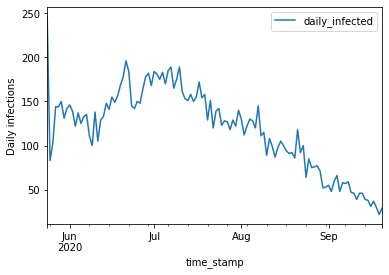

In [73]:
summary.groupby(['time_stamp']).sum().plot(y=['daily_infected'])
plt.ylabel('Daily infections')
plt.show()

### Hospital and intensive care

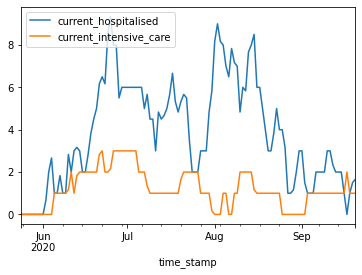

In [78]:
summary.groupby(['time_stamp']).sum().plot(y=['current_hospitalised', 'current_intensive_care'])
plt.show()

### Cumulative infections by age

In [79]:
infections_df = read.get_table_with_extras('infections',
                                           'infected_ids')

2022-01-04 14:25:22,919 - june.records.records_reader - INFO - Loading infections table
2022-01-04 14:25:22,957 - june.records.records_reader - INFO - Loading population table
2022-01-04 14:25:23,020 - june.records.records_reader - INFO - Merging infection and population tables
2022-01-04 14:25:23,029 - june.records.records_reader - INFO - Loading geography table
2022-01-04 14:25:23,059 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [80]:
deaths_df = read.get_table_with_extras('deaths', 
                                       'dead_person_ids')

2022-01-04 14:25:23,651 - june.records.records_reader - INFO - Loading deaths table
2022-01-04 14:25:23,658 - june.records.records_reader - INFO - Loading population table
2022-01-04 14:25:23,712 - june.records.records_reader - INFO - Merging infection and population tables
2022-01-04 14:25:23,715 - june.records.records_reader - INFO - Loading geography table
2022-01-04 14:25:23,742 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [81]:
age_bins = (0,20,60,100)

In [82]:
infected_by_age = infections_df.groupby([pd.cut(infections_df['age'],
            bins=age_bins), 'timestamp']).size()

In [83]:
people_df = read.table_to_df('population')

In [84]:
n_by_age = people_df.groupby(pd.cut(people_df['age'],
            bins=age_bins)).size()

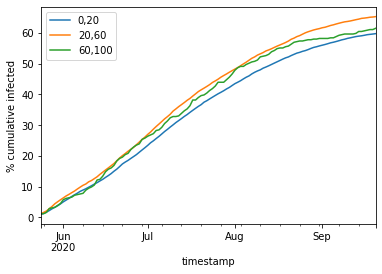

In [87]:
(100*infected_by_age/n_by_age).xs(10).cumsum().plot(label='0,20')
(100*infected_by_age/n_by_age).xs(30).cumsum().plot(label='20,60')
(100*infected_by_age/n_by_age).xs(70).cumsum().plot(label='60,100')
plt.ylabel("% cumulative infected")
plt.legend()

### Where people get infected

In [88]:
locations_df = infections_df.groupby(['location_specs', 
                                'timestamp']).size()

<AxesSubplot:xlabel='timestamp'>

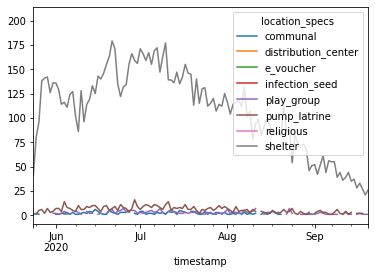

In [89]:
locations_df.unstack(level=0).plot()

Text(0.5, 0, 'location')

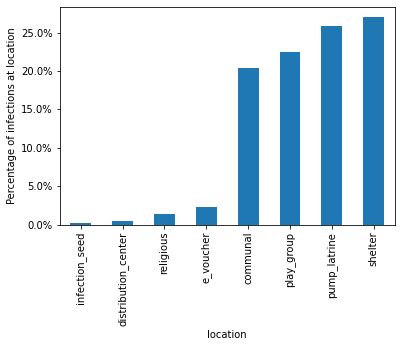

In [90]:
import matplotlib.ticker as mtick
location_counts_df = locations_df.groupby('location_specs').size()
location_counts_df = 100*location_counts_df / location_counts_df.sum()
ax = location_counts_df.sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')